# Old Code

Trial 5 Complete [00h 07m 42s]
val_accuracy: 0.994962215423584

Best val_accuracy So Far: 0.997481107711792
Total elapsed time: 00h 24m 32s

Best Hyperparameters:
conv_filters: 96
kernel_size: 3
lstm_units: 96
dense_units: 64
dropout_rate: 0.4
Epoch 1/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 14s 238ms/step - accuracy: 0.8513 - loss: 0.5297 - val_accuracy: 0.8992 - val_loss: 0.5601 - learning_rate: 0.0010
Epoch 2/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 231ms/step - accuracy: 0.9065 - loss: 0.3219 - val_accuracy: 0.8992 - val_loss: 0.3958 - learning_rate: 0.0010
Epoch 3/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 21s 230ms/step - accuracy: 0.9427 - loss: 0.1777 - val_accuracy: 0.8992 - val_loss: 0.5079 - learning_rate: 0.0010
Epoch 4/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 231ms/step - accuracy: 0.9486 - loss: 0.1560 - val_accuracy: 0.6826 - val_loss: 0.6789 - learning_rate: 0.0010
Epoch 5/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step - accuracy: 0.9567 - loss: 0.1366
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.000

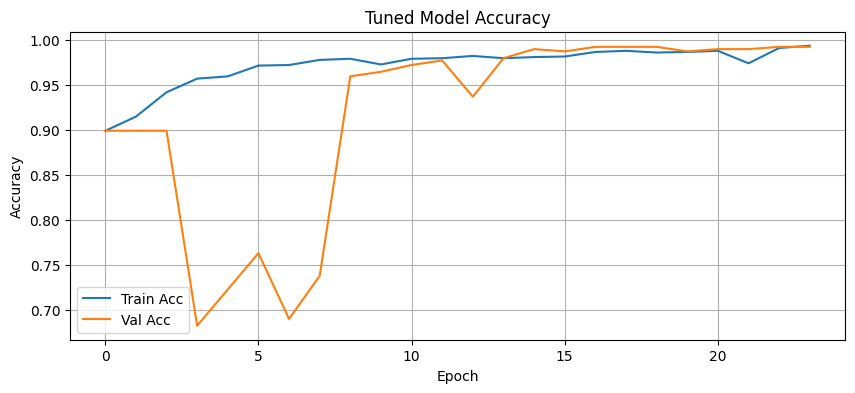

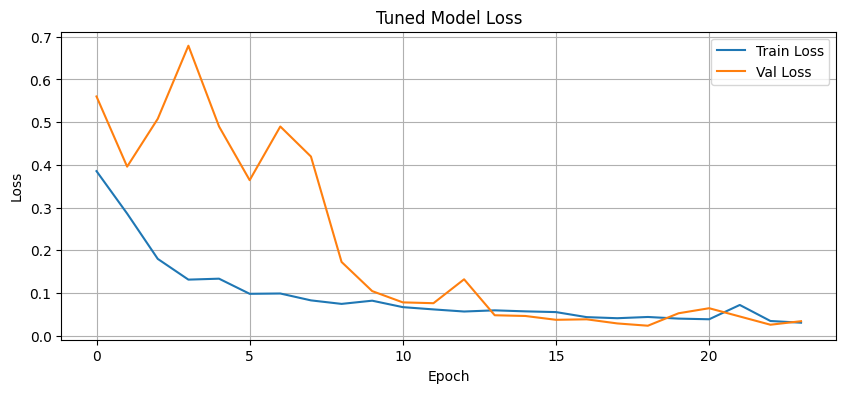

In [ ]:
# --- Imports ---
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models, Input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from kerastuner.tuners import RandomSearch  # Or use Hyperband/Bayesian if preferred
import os

# --- Load and preprocess data ---
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Objective_4 Coding/Copy of balanced_synthetic_gene_expression.csv')

# Filter out classes with only 1 sample
class_counts = df['Condition'].value_counts()
valid_classes = class_counts[class_counts > 1].index
df = df[df['Condition'].isin(valid_classes)]

# Features and labels
X = df.drop(['Sample_ID', 'Condition'], axis=1)
y = df['Condition']

# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_categorical = to_categorical(y_encoded)

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-validation split
x_train, x_val, y_train, y_val = train_test_split(
    X_scaled, y_categorical, test_size=0.2, random_state=42
)

# --- Hyperparameter Tuning Model ---
def build_model(hp):
    inputs = Input(shape=(x_train.shape[1],))
    x = layers.Reshape((x_train.shape[1], 1))(inputs)

    x = layers.Conv1D(
        filters=hp.Int('conv_filters', min_value=32, max_value=128, step=32),
        kernel_size=hp.Choice('kernel_size', values=[3, 5, 7]),
        activation='relu',
        padding='same'
    )(x)

    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling1D(pool_size=2)(x)

    x = layers.LSTM(hp.Int('lstm_units', min_value=32, max_value=128, step=32))(x)
    x = layers.Dense(hp.Int('dense_units', min_value=32, max_value=128, step=32), activation='relu')(x)
    x = layers.Dropout(hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1))(x)

    outputs = layers.Dense(y_train.shape[1], activation='softmax')(x)

    model = models.Model(inputs=inputs, outputs=outputs)
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# --- Keras Tuner Setup ---
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=1,
    directory='tuner_dir',
    project_name='cnn_lstm_gene_expression'
)

# --- Start Search ---
tuner.search(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=50,  # max possible, will stop early
    batch_size=32,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
    ]
)

# --- Get Best Hyperparameters ---
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print("\nBest Hyperparameters:")
for hp in best_hps.values.keys():
    print(f"{hp}: {best_hps.get(hp)}")

# --- Rebuild and Train the Best Model ---
best_model = tuner.hypermodel.build(best_hps)

history = best_model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
    ]
)

# --- Save Best Model and History ---
best_model.save("best_cnn_lstm_tuned_model.h5")

with open('cnn_lstm_training_history_tuned.pkl', 'wb') as f:
    pickle.dump(history.history, f)

# --- Plot Accuracy ---
plt.figure(figsize=(10, 4))
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Tuned Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# --- Plot Loss ---
plt.figure(figsize=(10, 4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Tuned Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# --- Imports ---
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.models import load_model

# --- Load model ---
model = load_model("best_cnn_lstm_tuned_model.h5")

# --- Load and preprocess data (must match training) ---
df = pd.read_csv('//content/drive/MyDrive/Colab Notebooks/balanced_synthetic_gene_expression.csv')
df = df[df['Condition'].map(df['Condition'].value_counts()) > 1]

X = df.drop(['Sample_ID', 'Condition'], axis=1)
y = df['Condition']
feature_names = X.columns.tolist()

le = LabelEncoder()
y_encoded = le.fit_transform(y)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split (same way as training)
split = int(0.8 * len(X_scaled))
x_train = X_scaled[:split]
x_val = X_scaled[split:]
sample_to_explain = x_val[:50]

# --- Define prediction wrapper ---
def model_predict(x):
    x_reshaped = x.reshape((x.shape[0], x.shape[1], 1))
    return model.predict(x_reshaped)

# --- Run SHAP (KernelExplainer for CNN-LSTM) ---
background = x_train[np.random.choice(x_train.shape[0], 100, replace=False)]
explainer = shap.KernelExplainer(model_predict, background)
shap_values = explainer.shap_values(sample_to_explain, nsamples=100)

# --- Save SHAP values ---
with open("shap_values.pkl", "wb") as f:
    pickle.dump(shap_values, f)

# --- Summary Plot (Global Explanation) ---
shap.summary_plot(shap_values[0], sample_to_explain, feature_names=feature_names)
plt.gcf().set_size_inches(10, 6)
plt.savefig("shap_summary_class0.png", bbox_inches="tight")

# --- Bar Plot (Top Features, Global View) ---
shap.plots.bar(
    shap.Explanation(values=shap_values[0], data=sample_to_explain, feature_names=feature_names),
    show=True
)
plt.savefig("shap_bar_plot_class0.png", bbox_inches="tight")

# --- Per-Class Summary Plots ---
for i, class_name in enumerate(le.classes_):
    print(f"\n🧬 Top features for class: {class_name}")
    shap.summary_plot(shap_values[i], sample_to_explain, feature_names=feature_names, show=True)
    plt.gcf().set_size_inches(10, 6)
    plt.savefig(f"shap_summary_{class_name}.png", bbox_inches="tight")

# --- Local Force Plot (First Sample) ---
shap.force_plot(
    explainer.expected_value[0],
    shap_values[0][0],
    sample_to_explain[0],
    feature_names=feature_names,
    matplotlib=True
)

# --- Save SHAP values to CSV for analysis/supplement ---
shap_df = pd.DataFrame(shap_values[0], columns=feature_names)
shap_df.to_csv("shap_values_class0.csv", index=False)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 80ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=2.338e-01, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 6 iterations, i.e. alpha=2.060e-01, with an active set of 6 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/shap/explainers/_kernel.py:708: UserWarning: Linear regression equation is singular, a least squares solutions is used instead.
To avoid this situation and get a regular matrix do one of the following:
1) turn up the number of samples,
2) turn up

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 80ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 1 iterations, i.e. alpha=2.634e+00, with an active set of 1 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 80ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 6 iterations, i.e. alpha=2.041e+00, with an active set of 6 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 79ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=5.545e-01, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 7 iterations, i.e. alpha=4.490e-01, with an active set of 7 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 8 iterations, i.e. alpha=3.431e-01, with an active set of 8 regressors, and the smallest cholesky pivot element being 2

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 80ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 1 iterations, i.e. alpha=1.582e+00, with an active set of 1 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=1.043e+00, with an active set of 2 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=7.910e-01, with an active set of 4 regressors, and the smallest cholesky pivot element being 2

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 80ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 6 iterations, i.e. alpha=2.792e-01, with an active set of 6 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=1.786e+00, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=1.270e+00, with an active set of 5 regressors, and the smallest cholesky pivot element being 2

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 80ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=1.905e-01, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 6 iterations, i.e. alpha=1.791e-01, with an active set of 6 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 7 iterations, i.e. alpha=1.731e+00, with an active set of 6 regressors, and the smallest cholesky pivot element being 2

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 80ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=2.503e-01, with an active set of 5 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 80ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 8 iterations, i.e. alpha=6.881e-01, with an active set of 7 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 79ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 1 iterations, i.e. alpha=1.216e+00, with an active set of 1 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 80ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=1.666e+00, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 80ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 9 iterations, i.e. alpha=1.164e+00, with an active set of 8 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 80ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=2.793e-01, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=2.354e+00, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 80ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 1 iterations, i.e. alpha=1.784e+00, with an active set of 1 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 80ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 8 iterations, i.e. alpha=2.476e-01, with an active set of 7 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=2.116e+00, with an active set of 5 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 80ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=1.533e+00, with an active set of 5 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 80ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=9.962e-01, with an active set of 2 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 7 iterations, i.e. alpha=5.139e-01, with an active set of 7 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 80ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 6 iterations, i.e. alpha=2.955e-01, with an active set of 6 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=1.742e+00, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 80ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 7 iterations, i.e. alpha=1.145e+00, with an active set of 7 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 80ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 7 iterations, i.e. alpha=3.629e-01, with an active set of 7 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 80ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 6 iterations, i.e. alpha=1.863e+00, with an active set of 5 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 80ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=2.334e+00, with an active set of 2 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=2.201e+00, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 7 iterations, i.e. alpha=1.690e+00, with an active set of 6 regressors, and the smallest cholesky pivot element being 2

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 80ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=2.492e-01, with an active set of 5 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 8 iterations, i.e. alpha=1.945e-01, with an active set of 8 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 9 iterations, i.e. alpha=1.761e-01, with an active set of 9 regressors, and the smallest cholesky pivot element being 2

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 81ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=2.404e-01, with an active set of 2 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 9 iterations, i.e. alpha=2.013e-01, with an active set of 8 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 9 iterations, i.e. alpha=1.122e+00, with an active set of 8 regressors, and the smallest cholesky pivot element being 2

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 80ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 6 iterations, i.e. alpha=5.197e-01, with an active set of 6 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 8 iterations, i.e. alpha=2.240e+00, with an active set of 7 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 80ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=1.583e+00, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 6 iterations, i.e. alpha=1.520e+00, with an active set of 6 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=1.401e+00, with an active set of 4 regressors, and the smallest cholesky pivot element being 2

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 80ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 1 iterations, i.e. alpha=1.985e+00, with an active set of 1 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=1.055e+00, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 80ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 6 iterations, i.e. alpha=4.513e-01, with an active set of 6 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=2.089e+00, with an active set of 2 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 8 iterations, i.e. alpha=1.685e+00, with an active set of 6 regressors, and the smallest cholesky pivot element being 2

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 80ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=1.107e+00, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 80ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 1 iterations, i.e. alpha=2.286e+00, with an active set of 1 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=1.981e+00, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 9 iterations, i.e. alpha=1.162e+00, with an active set of 8 regressors, and the smallest cholesky pivot element being 2

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 80ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=1.555e+00, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 9 iterations, i.e. alpha=1.000e+00, with an active set of 7 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 80ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 1 iterations, i.e. alpha=1.307e+00, with an active set of 1 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=8.281e-01, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=6.537e-01, with an active set of 5 regressors, and the smallest cholesky pivot element being 2

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 80ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 6 iterations, i.e. alpha=3.483e-01, with an active set of 6 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 80ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 1 iterations, i.e. alpha=1.138e+00, with an active set of 1 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 80ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=2.108e+00, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 80ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=1.560e-01, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=1.622e+00, with an active set of 5 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=1.707e+00, with an active set of 2 regressors, and the smallest cholesky pivot element being 2

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 80ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=1.686e-01, with an active set of 5 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 8 iterations, i.e. alpha=1.481e-01, with an active set of 8 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=1.487e+00, with an active set of 2 regressors, and the smallest cholesky pivot element being 2

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 81ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=1.918e+00, with an active set of 2 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 8 iterations, i.e. alpha=1.437e+00, with an active set of 7 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 8 iterations, i.e. alpha=7.484e-01, with an active set of 7 regressors, and the smallest cholesky pivot element being 2

AssertionError: The shape of the shap_values matrix does not match the shape of the provided data matrix.

<Figure size 640x480 with 0 Axes>

In [ ]:
flat_sample = sample_to_explain.reshape(sample_to_explain.shape[0], sample_to_explain.shape[1])


In [ ]:
import numpy as np

print("Shape of shap_values[0]:", np.array(shap_values[0]).shape)
print("Shape of sample_to_explain:", sample_to_explain.shape)


Shape of shap_values[0]: (11519, 3)
Shape of sample_to_explain: (50, 11519)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 80ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=2.577e-01, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 80ms/step


/usr/local/lib/python3.11/dist-packages/shap/explainers/_kernel.py:708: UserWarning: Linear regression equation is singular, a least squares solutions is used instead.
To avoid this situation and get a regular matrix do one of the following:
1) turn up the number of samples,
2) turn up the L1 regularization with num_features(N) where N is less than the number of samples,
3) group features together to reduce the number of inputs that need to be explained.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 80ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 7 iterations, i.e. alpha=3.708e-01, with an active set of 6 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 80ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=3.972e-01, with an active set of 5 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 80ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=4.094e-01, with an active set of 5 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 9 iterations, i.e. alpha=3.994e-01, with an active set of 9 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 80ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 6 iterations, i.e. alpha=6.094e-01, with an active set of 6 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 8 iterations, i.e. alpha=5.885e-01, with an active set of 7 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 80ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 8 iterations, i.e. alpha=2.045e-01, with an active set of 8 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 80ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=1.860e-01, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 9 iterations, i.e. alpha=1.126e-01, with an active set of 8 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 80ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=3.524e-01, with an active set of 5 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 6 iterations, i.e. alpha=3.524e-01, with an active set of 6 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 80ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 7 iterations, i.e. alpha=3.487e-01, with an active set of 7 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 80ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=2.105e-01, with an active set of 5 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 6 iterations, i.e. alpha=1.970e-01, with an active set of 6 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 8 iterations, i.e. alpha=1.792e-01, with an active set of 8 regressors, and the smallest cholesky pivot element being 2

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 80ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=1.943e-01, with an active set of 5 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 80ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 9 iterations, i.e. alpha=1.815e-01, with an active set of 8 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 80ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 7 iterations, i.e. alpha=4.911e-01, with an active set of 6 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 7 iterations, i.e. alpha=4.908e-01, with an active set of 6 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 80ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=2.385e-01, with an active set of 5 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 6 iterations, i.e. alpha=2.112e-01, with an active set of 6 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 8 iterations, i.e. alpha=2.079e-01, with an active set of 8 regressors, and the smallest cholesky pivot element being 2

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 80ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 6 iterations, i.e. alpha=5.294e-01, with an active set of 6 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 80ms/step


<Figure size 640x480 with 0 Axes>

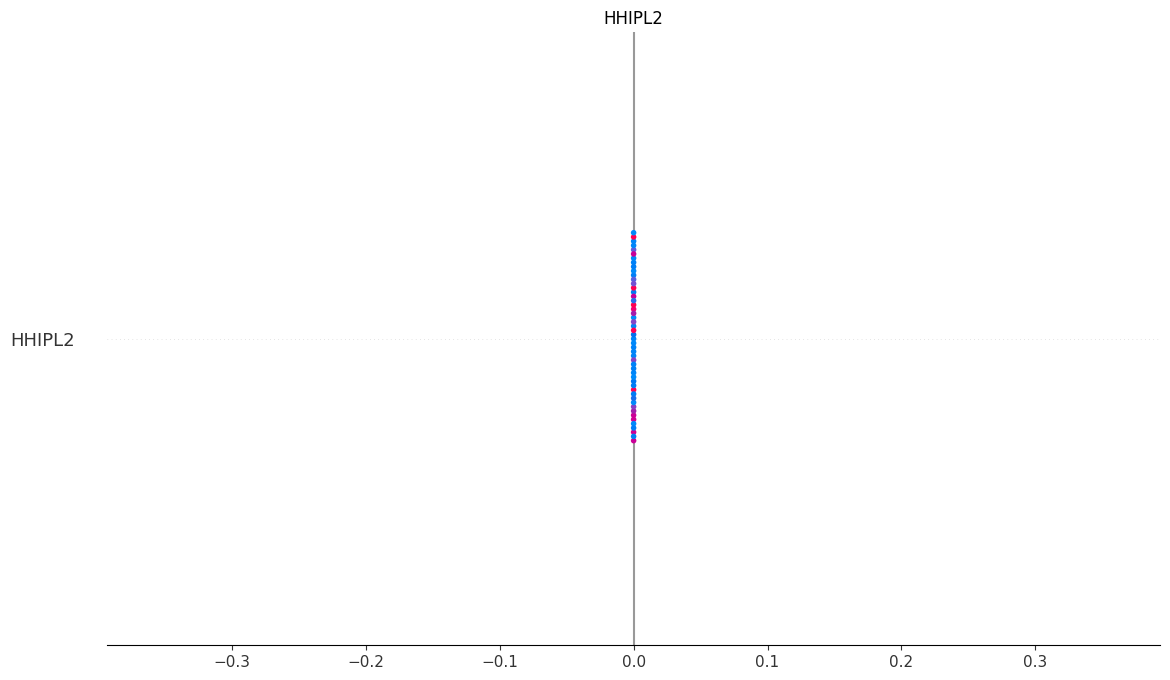

<Figure size 1000x600 with 0 Axes>

In [ ]:
# --- Imports ---
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.models import load_model

# --- Load trained model ---
model = load_model("best_cnn_lstm_tuned_model.h5")

# --- Load and preprocess data (as during training) ---
df = pd.read_csv('//content/drive/MyDrive/Colab Notebooks/balanced_synthetic_gene_expression.csv')
df = df[df['Condition'].map(df['Condition'].value_counts()) > 1]

X = df.drop(['Sample_ID', 'Condition'], axis=1)
y = df['Condition']
feature_names = X.columns.tolist()

# Encode and scale
le = LabelEncoder()
y_encoded = le.fit_transform(y)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split
split = int(0.8 * len(X_scaled))
x_train = X_scaled[:split]
x_val = X_scaled[split:]
sample_to_explain = x_val[:50]  # 50 samples for explanation

# --- Model prediction wrapper (focus on Class 0 only) ---
def model_predict(x):
    x_reshaped = x.reshape((x.shape[0], x.shape[1], 1))
    preds = model.predict(x_reshaped)
    return preds[:, 0:1]  # 👈 Only class 0

# --- SHAP Explainer ---
background = x_train[np.random.choice(x_train.shape[0], 100, replace=False)]
explainer = shap.KernelExplainer(model_predict, background)
shap_values = explainer.shap_values(sample_to_explain, nsamples=100)

# --- Save SHAP values ---
with open("shap_values_class0.pkl", "wb") as f:
    pickle.dump(shap_values, f)

# --- Summary Plot ---
shap.summary_plot(shap_values, sample_to_explain, feature_names=feature_names)
plt.gcf().set_size_inches(10, 6)
plt.savefig("shap_summary_class0.png", bbox_inches="tight")


In [ ]:
shap.plots.bar(shap.Explanation(values=shap_values, data=sample_to_explain, feature_names=feature_names))


TypeError: only integer scalar arrays can be converted to a scalar index

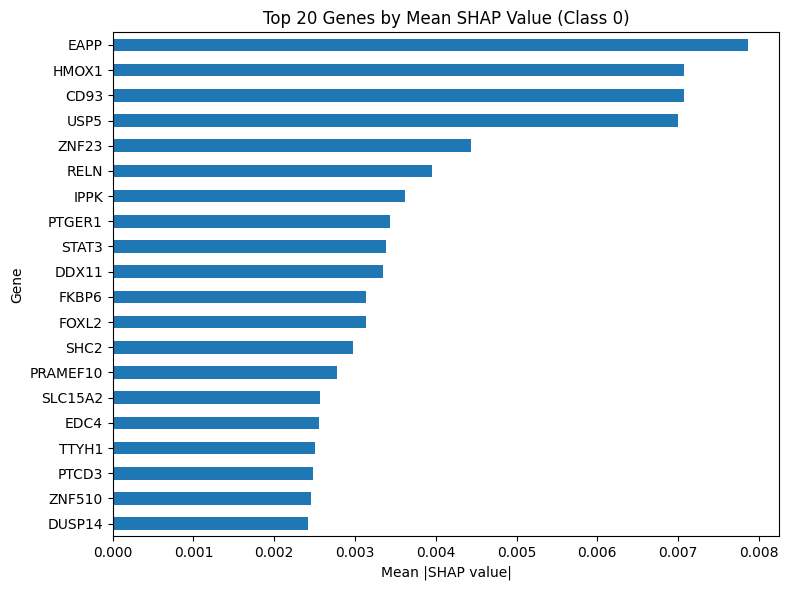

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Compute mean absolute SHAP values and flatten
mean_abs_shap = np.mean(np.abs(np.array(shap_values)), axis=0).flatten()

# Create and sort DataFrame
shap_df = pd.DataFrame({
    'Gene': feature_names,
    'Mean |SHAP|': mean_abs_shap
}).sort_values(by='Mean |SHAP|', ascending=False)

# Plot top 20 genes
shap_df.head(20).plot(kind='barh', x='Gene', y='Mean |SHAP|', figsize=(8, 6), legend=False)
plt.title("Top 20 Genes by Mean SHAP Value (Class 0)")
plt.xlabel("Mean |SHAP value|")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig("shap_bar_manual_class0.png")
plt.show()


In [ ]:
print("🔢 Length of feature_names:", len(feature_names))
print("🔢 Shape of mean_abs_shap_all:", mean_abs_shap_all.shape)


🔢 Length of feature_names: 11519
🔢 Shape of mean_abs_shap_all: (1,)


In [ ]:
def model_predict(x):
    x_reshaped = x.reshape((x.shape[0], x.shape[1], 1))
    return model.predict(x_reshaped)  # 👈 NO slicing, return all class probs


In [ ]:
explainer = shap.KernelExplainer(model_predict, background)
shap_values = explainer.shap_values(sample_to_explain, nsamples=100)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 26s 83ms/step


/usr/local/lib/python3.11/dist-packages/shap/explainers/_kernel.py:708: UserWarning: Linear regression equation is singular, a least squares solutions is used instead.
To avoid this situation and get a regular matrix do one of the following:
1) turn up the number of samples,
2) turn up the L1 regularization with num_features(N) where N is less than the number of samples,
3) group features together to reduce the number of inputs that need to be explained.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=1.885e+00, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 80ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 8 iterations, i.e. alpha=1.853e+00, with an active set of 7 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 8 iterations, i.e. alpha=6.670e-01, with an active set of 6 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 26s 81ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 7 iterations, i.e. alpha=2.970e-01, with an active set of 7 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 7 iterations, i.e. alpha=7.160e-01, with an active set of 6 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 80ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 9 iterations, i.e. alpha=5.813e-01, with an active set of 8 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 80ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=2.067e+00, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 1 iterations, i.e. alpha=2.292e+00, with an active set of 1 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 80ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 8 iterations, i.e. alpha=1.376e+00, with an active set of 7 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=1.856e+00, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 6 iterations, i.e. alpha=1.310e+00, with an active set of 6 regressors, and the smallest cholesky pivot element being 2

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 80ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=2.072e+00, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=2.017e+00, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=2.009e+00, with an active set of 4 regressors, and the smallest cholesky pivot element being 2

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 80ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 9 iterations, i.e. alpha=2.165e+00, with an active set of 9 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 80ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=1.674e+00, with an active set of 5 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 8 iterations, i.e. alpha=9.839e-01, with an active set of 7 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 9 iterations, i.e. alpha=9.839e-01, with an active set of 8 regressors, and the smallest cholesky pivot element being 2

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 80ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 7 iterations, i.e. alpha=2.836e-01, with an active set of 7 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=2.228e+00, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 80ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=3.531e-01, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 6 iterations, i.e. alpha=1.124e+00, with an active set of 6 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 80ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=1.975e+00, with an active set of 2 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=1.695e+00, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 80ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 8 iterations, i.e. alpha=2.044e-01, with an active set of 7 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=1.555e+00, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 8 iterations, i.e. alpha=1.068e+00, with an active set of 6 regressors, and the smallest cholesky pivot element being 2

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 80ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=3.697e-01, with an active set of 2 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 80ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 1 iterations, i.e. alpha=1.770e+00, with an active set of 1 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=1.289e+00, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 6 iterations, i.e. alpha=1.289e+00, with an active set of 5 regressors, and the smallest cholesky pivot element being 2

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 80ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=3.379e-01, with an active set of 5 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=1.967e+00, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=1.155e+00, with an active set of 5 regressors, and the smallest cholesky pivot element being 2

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 80ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=1.313e+00, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 7 iterations, i.e. alpha=1.313e+00, with an active set of 6 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 80ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=1.925e+00, with an active set of 2 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 80ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=1.589e+00, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=8.367e-01, with an active set of 2 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=7.860e-01, with an active set of 3 regressors, and the smallest cholesky pivot element being 2

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 79ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=4.087e-01, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=1.790e+00, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 80ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 8 iterations, i.e. alpha=2.232e-01, with an active set of 8 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 7 iterations, i.e. alpha=1.654e+00, with an active set of 6 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 81ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 8 iterations, i.e. alpha=1.554e+00, with an active set of 6 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 8 iterations, i.e. alpha=1.552e+00, with an active set of 6 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 81ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=2.199e-01, with an active set of 5 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 80ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=2.131e+00, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 7 iterations, i.e. alpha=1.339e+00, with an active set of 6 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 80ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=2.212e+00, with an active set of 2 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=1.725e+00, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=1.060e+00, with an active set of 3 regressors, and the smallest cholesky pivot element being 2

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 80ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=2.418e+00, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 80ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 9 iterations, i.e. alpha=3.554e-01, with an active set of 9 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 81ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 9 iterations, i.e. alpha=2.419e-01, with an active set of 9 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=1.518e+00, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 6 iterations, i.e. alpha=1.053e+00, with an active set of 5 regressors, and the smallest cholesky pivot element being 2

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 80ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 1 iterations, i.e. alpha=1.398e+00, with an active set of 1 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=9.085e-01, with an active set of 2 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 9 iterations, i.e. alpha=7.435e-01, with an active set of 7 regressors, and the smallest cholesky pivot element being 2

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 80ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=1.328e+00, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 6 iterations, i.e. alpha=1.171e+00, with an active set of 6 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 8 iterations, i.e. alpha=1.119e+00, with an active set of 8 regressors, and the smallest cholesky pivot element being 2

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 80ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 1 iterations, i.e. alpha=2.251e-01, with an active set of 1 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 80ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=1.939e-01, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 7 iterations, i.e. alpha=1.043e+00, with an active set of 7 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 80ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=1.006e+00, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 80ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=1.030e+00, with an active set of 5 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 80ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=1.465e+00, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 80ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=4.609e-01, with an active set of 5 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 9 iterations, i.e. alpha=4.130e-01, with an active set of 9 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 80ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=1.403e+00, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 80ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 1 iterations, i.e. alpha=1.817e+00, with an active set of 1 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 8 iterations, i.e. alpha=1.254e+00, with an active set of 7 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 81ms/step


In [ ]:
print("Number of classes (SHAP outputs):", len(shap_values))  # Should match number of classes
print("shap_values[0] shape:", np.array(shap_values[0]).shape)


Number of classes (SHAP outputs): 50
shap_values[0] shape: (11519, 3)


In [ ]:
stacked = np.stack(shap_values, axis=0)  # shape: (classes, samples, features)
mean_abs_shap_all = np.mean(np.abs(stacked), axis=(0, 1)).flatten()


In [ ]:
!pip install -q -U keras-tuner


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 5.7 MB/s eta 0:00:00


## 12April 2025


In [ ]:
!pip install -q -U keras-tuner


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 5.7 MB/s eta 0:00:00


In [ ]:
# --- Imports ---
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models, Input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from kerastuner.tuners import RandomSearch
import os
import datetime
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix



# --- Load and preprocess data ---
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Objective_4 Coding/Copy of balanced_synthetic_gene_expression.csv')

# Filter out classes with only 1 sample
class_counts = df['Condition'].value_counts()
valid_classes = class_counts[class_counts > 1].index
df = df[df['Condition'].isin(valid_classes)]

# Features and labels
X = df.drop(['Sample_ID', 'Condition'], axis=1)
y = df['Condition']

# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_categorical = to_categorical(y_encoded)

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-validation split
x_train, x_val, y_train, y_val = train_test_split(
    X_scaled, y_categorical, test_size=0.2, random_state=42
)

# --- Hyperparameter Tuning Model ---
def build_model(hp):
    inputs = Input(shape=(x_train.shape[1],))
    x = layers.Reshape((x_train.shape[1], 1))(inputs)

    x = layers.Conv1D(
        filters=hp.Int('conv_filters', min_value=32, max_value=128, step=32),
        kernel_size=hp.Choice('kernel_size', values=[3, 5, 7]),
        activation='relu',
        padding='same'
    )(x)

    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling1D(pool_size=2)(x)

    x = layers.LSTM(hp.Int('lstm_units', min_value=32, max_value=128, step=32))(x)
    x = layers.Dense(hp.Int('dense_units', min_value=32, max_value=128, step=32), activation='relu')(x)
    x = layers.Dropout(hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1))(x)

    outputs = layers.Dense(y_train.shape[1], activation='softmax')(x)

    model = models.Model(inputs=inputs, outputs=outputs)
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# --- Keras Tuner Setup ---
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=1,
    directory='tuner_dir',
    project_name='cnn_lstm_gene_expression'
)

# --- Start Search ---
tuner.search(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
    ]
)

# --- Get Best Hyperparameters ---
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print("\nBest Hyperparameters:")
for hp in best_hps.values.keys():
    print(f"{hp}: {best_hps.get(hp)}")

# --- Rebuild and Train the Best Model ---
best_model = tuner.hypermodel.build(best_hps)

history = best_model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
    ]
)

# --- Create Output Directory ---
now = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
save_dir = f"/content/drive/MyDrive/Colab Notebooks/Objective_4 Coding/results_{now}"
os.makedirs(save_dir, exist_ok=True)

# --- Save Model and History ---
best_model.save(os.path.join(save_dir, "best_cnn_lstm_tuned_model.h5"))

with open(os.path.join(save_dir, 'cnn_lstm_training_history_tuned.pkl'), 'wb') as f:
    pickle.dump(history.history, f)

# --- Plot and Save Accuracy ---
plt.figure(figsize=(10, 4))
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Tuned Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(save_dir, 'accuracy_plot.png'), dpi=300)
plt.close()

# --- Plot and Save Loss ---
plt.figure(figsize=(10, 4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Tuned Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(save_dir, 'loss_plot.png'), dpi=300)
plt.close()

# --- Predictions and Evaluation ---
y_val_pred_probs = best_model.predict(x_val)
y_val_preds = np.argmax(y_val_pred_probs, axis=1)
y_val_true = np.argmax(y_val, axis=1)

# --- Confusion Matrix ---
cm = confusion_matrix(y_val_true, y_val_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.savefig(os.path.join(save_dir, 'confusion_matrix.png'), dpi=300)
plt.close()

# --- Classification Report ---
report = classification_report(y_val_true, y_val_preds, target_names=le.classes_, output_dict=True)
report_df = pd.DataFrame(report).transpose()
print(report_df)

# Save as CSV
report_df.to_csv(os.path.join(save_dir, 'evaluation_metrics.csv'))

# --- Save Data for SHAP Later ---
np.save(os.path.join(save_dir, 'y_val_preds.npy'), y_val_preds)
np.save(os.path.join(save_dir, 'y_val_true.npy'), y_val_true)
np.save(os.path.join(save_dir, 'x_val.npy'), x_val)
np.save(os.path.join(save_dir, 'x_train.npy'), x_train)
np.save(os.path.join(save_dir, 'y_train.npy'), y_train)


Trial 5 Complete [00h 13m 22s]
val_accuracy: 1.0

Best val_accuracy So Far: 1.0
Total elapsed time: 00h 36m 24s

Best Hyperparameters:
conv_filters: 32
kernel_size: 7
lstm_units: 32
dense_units: 96
dropout_rate: 0.2
Epoch 1/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 11s 158ms/step - accuracy: 0.7311 - loss: 0.7781 - val_accuracy: 0.8992 - val_loss: 0.5177 - learning_rate: 0.0010
Epoch 2/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 11s 168ms/step - accuracy: 0.9251 - loss: 0.2695 - val_accuracy: 0.8992 - val_loss: 0.4436 - learning_rate: 0.0010
Epoch 3/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 11s 177ms/step - accuracy: 0.9144 - loss: 0.2500 - val_accuracy: 0.8992 - val_loss: 0.3853 - learning_rate: 0.0010
Epoch 4/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 9s 158ms/step - accuracy: 0.9217 - loss: 0.1958 - val_accuracy: 0.9093 - val_loss: 0.3669 - learning_rate: 0.0010
Epoch 5/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 10s 158ms/step - accuracy: 0.9540 - loss: 0.1397 - val_accuracy: 0.8237 - val_loss: 0.4451 - learning_rate: 0.0010
Epoch 6/50
50/50 ━━━

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step
              precision    recall  f1-score     support
A              1.000000  0.812500  0.896552   16.000000
N              0.982955  1.000000  0.991404  173.000000
S              1.000000  1.000000  1.000000  208.000000
accuracy       0.992443  0.992443  0.992443    0.992443
macro avg      0.994318  0.937500  0.962652  397.000000
weighted avg   0.992572  0.992443  0.992085  397.000000


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# --- Imports ---
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import os
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.models import load_model

# --- Locate latest result folder ---
results_dir = "/content/drive/MyDrive/Colab Notebooks/Objective_4 Coding"
latest_results_dir = sorted([d for d in os.listdir(results_dir) if d.startswith("results_")])[-1]
save_path = os.path.join(results_dir, latest_results_dir)

# --- Load model ---
model = load_model(os.path.join(save_path, "best_cnn_lstm_tuned_model.h5"))

# --- Load data ---
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Objective_4 Coding/Copy of balanced_synthetic_gene_expression.csv')
df = df[df['Condition'].map(df['Condition'].value_counts()) > 1]

X = df.drop(['Sample_ID', 'Condition'], axis=1)
y = df['Condition']
feature_names = X.columns.tolist()

# --- Encode and scale ---
le = LabelEncoder()
y_encoded = le.fit_transform(y)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split
split = int(0.8 * len(X_scaled))
x_train = X_scaled[:split]
x_val = X_scaled[split:]
sample_to_explain = x_val[:50]

# --- Model prediction wrapper for SHAP ---
def model_predict(x):
    x_reshaped = x.reshape((x.shape[0], x.shape[1], 1))
    return model.predict(x_reshaped)

# Background data for KernelExplainer
background = x_train[np.random.choice(x_train.shape[0], 100, replace=False)]

# --- KernelExplainer ---
explainer = shap.KernelExplainer(model_predict, background)
shap_values = explainer.shap_values(sample_to_explain, nsamples=100)

# --- Save SHAP values ---
with open(os.path.join(save_path, "shap_values_class0.pkl"), "wb") as f:
    pickle.dump(shap_values, f)

# --- Summary Plot (Beeswarm) ---
plt.figure()
shap.summary_plot(shap_values[0], sample_to_explain, feature_names=feature_names, show=False)
plt.gcf().set_size_inches(10, 6)
plt.savefig(os.path.join(save_path, "shap_summary_class0.png"), bbox_inches="tight", dpi=300)
plt.close()

# --- Mean SHAP values ---
mean_abs_shap = np.mean(np.abs(np.array(shap_values[0])), axis=0).flatten()
shap_df = pd.DataFrame({'Gene': feature_names, 'Mean |SHAP|': mean_abs_shap})
shap_df = shap_df.sort_values(by='Mean |SHAP|', ascending=False)
shap_df.to_csv(os.path.join(save_path, "shap_mean_values_class0.csv"), index=False)

# --- Top 20 Bar Chart ---
plt.figure(figsize=(8, 6))
shap_df.head(20).plot(kind='barh', x='Gene', y='Mean |SHAP|', legend=False)
plt.title("Top 20 Genes by Mean SHAP Value (Class 0)")
plt.xlabel("Mean |SHAP value|")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig(os.path.join(save_path, "shap_bar_top20_class0.png"), dpi=300)
plt.close()

# --- Dependence Plot for Top Gene ---
top_gene = shap_df.iloc[0]['Gene']
gene_index = feature_names.index(top_gene)

plt.figure()
shap.dependence_plot(
    gene_index,
    shap_values[0],
    sample_to_explain,
    feature_names=feature_names,
    show=False
)
plt.tight_layout()
plt.savefig(os.path.join(save_path, f"shap_dependence_{top_gene}.png"), dpi=300)
plt.close()


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/Colab Notebooks/Objective_4 Coding'

In [ ]:
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import pickle
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Re-locate saved folder
results_dir = "/content/drive/MyDrive/Colab Notebooks/Objective_4 Coding"
latest_results_dir = sorted([d for d in os.listdir(results_dir) if d.startswith("results_")])[-1]
save_path = os.path.join(results_dir, latest_results_dir)

# Load SHAP values
with open(os.path.join(save_path, "shap_values_class0.pkl"), "rb") as f:
    shap_values = pickle.load(f)

# Load and preprocess sample data again
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Objective_4 Coding/Copy of balanced_synthetic_gene_expression.csv')
df = df[df['Condition'].map(df['Condition'].value_counts()) > 1]
X = df.drop(['Sample_ID', 'Condition'], axis=1)
feature_names = X.columns.tolist()

le = LabelEncoder()
y_encoded = le.fit_transform(df['Condition'])
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
x_val = X_scaled[int(0.8 * len(X_scaled)):]
sample_to_explain = x_val[:50]

# Ensure matching shape
shap_matrix = np.array(shap_values)
if len(sample_to_explain.shape) == 3:
    sample_to_explain = np.squeeze(sample_to_explain, axis=2)

# Plot summary
plt.figure()
shap.summary_plot(shap_matrix, sample_to_explain, feature_names=feature_names, show=False)
plt.gcf().set_size_inches(10, 6)
plt.savefig(os.path.join(save_path, "shap_summary_class0.png"), bbox_inches="tight", dpi=300)
plt.close()


<Figure size 640x480 with 0 Axes>

In [6]:
/content/drive/MyDrive/Colab Notebooks/Objective_4 Coding


NameError: name 'content' is not defined

In [5]:
# --- Imports ---
import shap
import numpy as np
import pandas as pd
import pickle
import os
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.models import load_model

# --- Locate latest result folder ---
results_dir = "/content/drive/MyDrive/Colab Notebooks/Objective_4 Coding"
latest_results_dir = sorted([d for d in os.listdir(results_dir) if d.startswith("results_")])[-1]
save_path = os.path.join(results_dir, latest_results_dir)

# --- Load model ---
model = load_model(os.path.join(save_path, "best_cnn_lstm_tuned_model.h5"))

# --- Load data ---
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Objective_4 Coding/Copy of balanced_synthetic_gene_expression.csv')
df = df[df['Condition'].map(df['Condition'].value_counts()) > 1]

X = df.drop(['Sample_ID', 'Condition'], axis=1)
y = df['Condition']
feature_names = X.columns.tolist()

# --- Encode and scale ---
le = LabelEncoder()
y_encoded = le.fit_transform(y)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --- Split ---
split = int(0.8 * len(X_scaled))
x_train = X_scaled[:split]
x_val = X_scaled[split:]
sample_to_explain = x_val[:50]

# --- Model prediction wrapper ---
def model_predict(x):
    x_reshaped = x.reshape((x.shape[0], x.shape[1], 1))
    return model.predict(x_reshaped)

# --- Background for SHAP ---
background = x_train[np.random.choice(x_train.shape[0], 100, replace=False)]

# --- KernelExplainer ---
explainer = shap.KernelExplainer(model_predict, background)
shap_values = explainer.shap_values(sample_to_explain, nsamples=100)

# --- Save SHAP values ---
with open(os.path.join(save_path, "shap_values_class0.pkl"), "wb") as f:
    pickle.dump(shap_values, f)

# Optional: Save sample and background if needed later
np.save(os.path.join(save_path, "shap_sample_to_explain.npy"), sample_to_explain)
np.save(os.path.join(save_path, "shap_background.npy"), background)


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/Colab Notebooks/Objective_4 Coding'

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import pickle

# --- Setup paths ---
results_dir = "/content/drive/MyDrive/Colab Notebooks/Objective_4 Coding"
latest_results_dir = sorted([d for d in os.listdir(results_dir) if d.startswith("results_")])[-1]
save_path = os.path.join(results_dir, latest_results_dir)

# --- Load saved SHAP values and supporting data ---
with open(os.path.join(save_path, "shap_values_class0.pkl"), "rb") as f:
    shap_values = pickle.load(f)

sample_to_explain = np.load(os.path.join(save_path, "shap_sample_to_explain.npy"))
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Objective_4 Coding/Copy of balanced_synthetic_gene_expression.csv')
df = df[df['Condition'].map(df['Condition'].value_counts()) > 1]
X = df.drop(['Sample_ID', 'Condition'], axis=1)
feature_names = X.columns.tolist()

# --- Mean SHAP values ---
shap_array = np.array(shap_values[0])
mean_abs_shap = np.mean(np.abs(shap_array), axis=0)
shap_df = pd.DataFrame({'Gene': feature_names, 'Mean |SHAP|': mean_abs_shap})
shap_df = shap_df.sort_values(by='Mean |SHAP|', ascending=False)
shap_df.to_csv(os.path.join(save_path, "shap_mean_values_class0.csv"), index=False)

# --- Bar Plot: Top 20 Genes ---
top20 = shap_df.head(20)
plt.figure(figsize=(8, 6))
plt.barh(top20['Gene'][::-1], top20['Mean |SHAP|'][::-1])
plt.title("Top 20 Genes by Mean SHAP Value (Class 0)")
plt.xlabel("Mean |SHAP|")
plt.tight_layout()
plt.savefig(os.path.join(save_path, "shap_bar_top20_class0.png"), dpi=300)
plt.close()

# --- Bar Plot: Top 100 Genes ---
top100 = shap_df.head(100)
plt.figure(figsize=(10, 16))
plt.barh(top100['Gene'][::-1], top100['Mean |SHAP|'][::-1])
plt.title("Top 100 Genes by Mean SHAP Value (Class 0)")
plt.xlabel("Mean |SHAP|")
plt.tight_layout()
plt.savefig(os.path.join(save_path, "shap_bar_top100_class0.png"), dpi=300)
plt.close()

# --- Dependence Plot for Top Gene ---
top_gene = shap_df.iloc[0]['Gene']
top_index = feature_names.index(top_gene)

plt.figure(figsize=(8, 6))
plt.scatter(sample_to_explain[:, top_index], shap_array[:, top_index], alpha=0.6)
plt.title(f"Dependence Plot for {top_gene}")
plt.xlabel(f"{top_gene} Expression (normalized)")
plt.ylabel("SHAP Value")
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(save_path, f"shap_dependence_{top_gene}.png"), dpi=300)
plt.close()

# --- SHAP Heatmap ---
plt.figure(figsize=(16, 10))
plt.imshow(shap_array, aspect='auto', cmap='coolwarm')
plt.colorbar(label='SHAP Value')
plt.xticks(ticks=np.arange(len(feature_names)), labels=feature_names, rotation=90, fontsize=6)
plt.yticks([])
plt.title("SHAP Value Heatmap (Top 50 Samples x All Genes)")
plt.xlabel("Genes")
plt.ylabel("Samples")
plt.tight_layout()
plt.savefig(os.path.join(save_path, "shap_heatmap_class0.png"), dpi=300)
plt.close()


## VSCODE

In [9]:
!pip install keras-tuner --upgrade



   ---------------------------------------- 0.0/129.1 kB ? eta -:--:--
   ---------------------------------------- 129.1/129.1 kB 3.8 MB/s eta 0:00:00


In [4]:
import tensorflow as tf
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available: 0


In [ ]:
# --- Imports ---
import pandas as pd
import numpy as np
import os
import datetime
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix

# --- Device Setup ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🚀 Using device: {device}")

# --- Load and preprocess data ---
df = pd.read_csv('balanced_synthetic_gene_expression.csv')

class_counts = df['Condition'].value_counts()
valid_classes = class_counts[class_counts > 1].index
df = df[df['Condition'].isin(valid_classes)]

X = df.drop(['Sample_ID', 'Condition'], axis=1)
y = df['Condition']

le = LabelEncoder()
y_encoded = le.fit_transform(y)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-validation split
X_train, X_val, y_train, y_val = train_test_split(
    X_scaled, y_encoded, test_size=0.2, random_state=42
)

# Convert to PyTorch tensors
torch_X_train = torch.tensor(X_train, dtype=torch.float32)
torch_y_train = torch.tensor(y_train, dtype=torch.long)
torch_X_val = torch.tensor(X_val, dtype=torch.float32)
torch_y_val = torch.tensor(y_val, dtype=torch.long)

# Create datasets and dataloaders
train_dataset = TensorDataset(torch_X_train, torch_y_train)
val_dataset = TensorDataset(torch_X_val, torch_y_val)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# --- Model Definition ---
class CNN_LSTM_Model(nn.Module):
    def __init__(self, input_size, num_classes):
        super(CNN_LSTM_Model, self).__init__()
        self.conv1 = nn.Conv1d(1, 64, kernel_size=5, padding=2)
        self.pool = nn.MaxPool1d(2)
        self.lstm = nn.LSTM(input_size=input_size//2, hidden_size=64, batch_first=True)
        self.fc1 = nn.Linear(64, 64)
        self.dropout = nn.Dropout(0.3)
        self.out = nn.Linear(64, num_classes)

    def forward(self, x):
        x = x.unsqueeze(1)  # (batch, 1, features)
        x = self.pool(torch.relu(self.conv1(x)))  # (batch, 64, features//2)
        x = x.permute(0, 2, 1)  # (batch, seq_len, features)
        _, (h_n, _) = self.lstm(x)
        x = torch.relu(self.fc1(h_n.squeeze(0)))
        x = self.dropout(x)
        return self.out(x)

model = CNN_LSTM_Model(input_size=X_train.shape[1], num_classes=len(np.unique(y))).to(device)

# --- Training Setup ---
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 50

train_loss_history, val_loss_history = [], []

# --- Training Loop ---
for epoch in range(epochs):
    model.train()
    train_loss = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    train_loss_history.append(train_loss / len(train_loader))
    val_loss_history.append(val_loss / len(val_loader))

    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {correct/total:.4f}")

# --- Save Results Directory ---
now = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
save_dir = f"./results_{now}"
os.makedirs(save_dir, exist_ok=True)

# --- Save Model ---
torch.save(model.state_dict(), os.path.join(save_dir, "cnn_lstm_model.pt"))

# --- Evaluation ---
model.eval()
y_val_preds = []
y_val_true = []
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        y_val_preds.extend(predicted.cpu().numpy())
        y_val_true.extend(labels.numpy())

# --- Confusion Matrix ---
cm = confusion_matrix(y_val_true, y_val_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.savefig(os.path.join(save_dir, 'confusion_matrix.png'), dpi=300)
plt.close()

# --- Classification Report ---
report = classification_report(y_val_true, y_val_preds, target_names=le.classes_, output_dict=True)
report_df = pd.DataFrame(report).transpose()
print(report_df)
report_df.to_csv(os.path.join(save_dir, 'evaluation_metrics.csv'))

# Save as CSV
report_df.to_csv(os.path.join(save_dir, 'evaluation_metrics.csv'))

# --- Save Data for SHAP Later ---
np.save(os.path.join(save_dir, 'y_val_preds.npy'), y_val_preds)
np.save(os.path.join(save_dir, 'y_val_true.npy'), y_val_true)
np.save(os.path.join(save_dir, 'x_val.npy'), x_val)
np.save(os.path.join(save_dir, 'x_train.npy'), x_train)
np.save(os.path.join(save_dir, 'y_train.npy'), y_train)

In [4]:
# --- Imports ---
import pandas as pd
import numpy as np
import os
import datetime
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix

# --- Device Setup ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🚀 Using device: {device}")

# --- Load and preprocess data ---
df = pd.read_csv('balanced_synthetic_gene_expression.csv')

class_counts = df['Condition'].value_counts()
valid_classes = class_counts[class_counts > 1].index
df = df[df['Condition'].isin(valid_classes)]

X = df.drop(['Sample_ID', 'Condition'], axis=1)
y = df['Condition']

le = LabelEncoder()
y_encoded = le.fit_transform(y)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-validation split
X_train, X_val, y_train, y_val = train_test_split(
    X_scaled, y_encoded, test_size=0.2, random_state=42
)

# Convert to PyTorch tensors
torch_X_train = torch.tensor(X_train, dtype=torch.float32)
torch_y_train = torch.tensor(y_train, dtype=torch.long)
torch_X_val = torch.tensor(X_val, dtype=torch.float32)
torch_y_val = torch.tensor(y_val, dtype=torch.long)

# Create datasets and dataloaders
train_dataset = TensorDataset(torch_X_train, torch_y_train)
val_dataset = TensorDataset(torch_X_val, torch_y_val)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# --- Model Definition ---
class CNN_LSTM_Model(nn.Module):
    def __init__(self, input_size, num_classes):
        super(CNN_LSTM_Model, self).__init__()
        self.conv1 = nn.Conv1d(1, 64, kernel_size=5, padding=2)
        self.pool = nn.MaxPool1d(2)
        self.lstm_input_dim = input_size // 2  # since pooling halves the dimension
        self.lstm = nn.LSTM(input_size=64, hidden_size=64, batch_first=True)
        self.fc1 = nn.Linear(64, 64)
        self.dropout = nn.Dropout(0.3)
        self.out = nn.Linear(64, num_classes)

    def forward(self, x):
        x = x.unsqueeze(1)  # (batch, 1, features)
        x = self.pool(torch.relu(self.conv1(x)))  # (batch, 64, features//2)
        x = x.permute(0, 2, 1)  # (batch, seq_len, features) => (batch, features//2, 64)
        _, (h_n, _) = self.lstm(x)  # LSTM expects input_size = 64
        x = torch.relu(self.fc1(h_n.squeeze(0)))
        x = self.dropout(x)
        return self.out(x)


model = CNN_LSTM_Model(input_size=X_train.shape[1], num_classes=len(np.unique(y))).to(device)

# --- Training Setup ---
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 50

train_loss_history, val_loss_history = [], []

# --- Training Loop ---
for epoch in range(epochs):
    model.train()
    train_loss = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    train_loss_history.append(train_loss / len(train_loader))
    val_loss_history.append(val_loss / len(val_loader))

    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {correct/total:.4f}")

# --- Save Results Directory ---
now = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
save_dir = f"./results_{now}"
os.makedirs(save_dir, exist_ok=True)

# --- Save Model ---
torch.save(model.state_dict(), os.path.join(save_dir, "cnn_lstm_model.pt"))

# --- Evaluation ---
model.eval()
y_val_preds = []
y_val_true = []
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        y_val_preds.extend(predicted.cpu().numpy())
        y_val_true.extend(labels.numpy())

# --- Confusion Matrix ---
cm = confusion_matrix(y_val_true, y_val_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.savefig(os.path.join(save_dir, 'confusion_matrix.png'), dpi=300)
plt.close()

# --- Classification Report ---
report = classification_report(y_val_true, y_val_preds, target_names=le.classes_, output_dict=True)
report_df = pd.DataFrame(report).transpose()
print(report_df)
report_df.to_csv(os.path.join(save_dir, 'evaluation_metrics.csv'))

# Save as CSV
report_df.to_csv(os.path.join(save_dir, 'evaluation_metrics.csv'))

# --- Save Data for SHAP Later ---
np.save(os.path.join(save_dir, 'y_val_preds.npy'), y_val_preds)
np.save(os.path.join(save_dir, 'y_val_true.npy'), y_val_true)
np.save(os.path.join(save_dir, 'x_val.npy'), x_val)
np.save(os.path.join(save_dir, 'x_train.npy'), x_train)
np.save(os.path.join(save_dir, 'y_train.npy'), y_train)

🚀 Using device: cuda
Epoch 1/50, Train Loss: 30.6952, Val Loss: 4.4667, Val Acc: 0.8992
Epoch 2/50, Train Loss: 16.2122, Val Loss: 4.2087, Val Acc: 0.8992
Epoch 3/50, Train Loss: 15.4670, Val Loss: 4.0955, Val Acc: 0.8992
Epoch 4/50, Train Loss: 15.4135, Val Loss: 4.3074, Val Acc: 0.8992
Epoch 5/50, Train Loss: 15.4093, Val Loss: 3.9837, Val Acc: 0.8992
Epoch 6/50, Train Loss: 14.4811, Val Loss: 3.7046, Val Acc: 0.8992
Epoch 7/50, Train Loss: 13.6779, Val Loss: 3.6662, Val Acc: 0.8992
Epoch 8/50, Train Loss: 11.7076, Val Loss: 2.5834, Val Acc: 0.8992
Epoch 9/50, Train Loss: 9.3363, Val Loss: 1.9352, Val Acc: 0.9572
Epoch 10/50, Train Loss: 9.2808, Val Loss: 1.8755, Val Acc: 0.9597
Epoch 11/50, Train Loss: 8.1888, Val Loss: 1.8210, Val Acc: 0.9547
Epoch 12/50, Train Loss: 7.8299, Val Loss: 1.6699, Val Acc: 0.9597
Epoch 13/50, Train Loss: 7.6638, Val Loss: 1.7463, Val Acc: 0.9547
Epoch 14/50, Train Loss: 7.3741, Val Loss: 1.6611, Val Acc: 0.9597
Epoch 15/50, Train Loss: 7.3427, Val Loss:

NameError: name 'x_val' is not defined

In [5]:
# --- Imports ---
import pandas as pd
import numpy as np
import os
import datetime
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix

# --- Device Setup ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🚀 Using device: {device}")

# --- Load and preprocess data ---
df = pd.read_csv('balanced_synthetic_gene_expression.csv')

class_counts = df['Condition'].value_counts()
valid_classes = class_counts[class_counts > 1].index
df = df[df['Condition'].isin(valid_classes)]

X = df.drop(['Sample_ID', 'Condition'], axis=1)
y = df['Condition']

le = LabelEncoder()
y_encoded = le.fit_transform(y)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-validation split
X_train, X_val, y_train, y_val = train_test_split(
    X_scaled, y_encoded, test_size=0.2, random_state=42
)

# Convert to PyTorch tensors
torch_X_train = torch.tensor(X_train, dtype=torch.float32)
torch_y_train = torch.tensor(y_train, dtype=torch.long)
torch_X_val = torch.tensor(X_val, dtype=torch.float32)
torch_y_val = torch.tensor(y_val, dtype=torch.long)

# Create datasets and dataloaders
train_dataset = TensorDataset(torch_X_train, torch_y_train)
val_dataset = TensorDataset(torch_X_val, torch_y_val)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# --- Model Definition ---
class CNN_LSTM_Model(nn.Module):
    def __init__(self, input_size, num_classes):
        super(CNN_LSTM_Model, self).__init__()
        self.conv1 = nn.Conv1d(1, 64, kernel_size=5, padding=2)
        self.pool = nn.MaxPool1d(2)
        self.lstm = nn.LSTM(input_size=64, hidden_size=64, batch_first=True)
        self.fc1 = nn.Linear(64, 64)
        self.dropout = nn.Dropout(0.3)
        self.out = nn.Linear(64, num_classes)

    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.pool(torch.relu(self.conv1(x)))
        x = x.permute(0, 2, 1)
        _, (h_n, _) = self.lstm(x)
        x = torch.relu(self.fc1(h_n.squeeze(0)))
        x = self.dropout(x)
        return self.out(x)

model = CNN_LSTM_Model(input_size=X_train.shape[1], num_classes=len(np.unique(y))).to(device)

# --- Training Setup ---
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 50
train_loss_history, val_loss_history = [], []

# --- Training Loop ---
for epoch in range(epochs):
    model.train()
    train_loss = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    train_loss_history.append(train_loss / len(train_loader))
    val_loss_history.append(val_loss / len(val_loader))
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {correct/total:.4f}")

# --- Save Results Directory ---
now = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
save_dir = f"./results_{now}"
os.makedirs(save_dir, exist_ok=True)

# --- Save Model ---
torch.save(model.state_dict(), os.path.join(save_dir, "cnn_lstm_model.pt"))

# --- Evaluation ---
model.eval()
y_val_preds = []
y_val_true = []
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        y_val_preds.extend(predicted.cpu().numpy())
        y_val_true.extend(labels.numpy())

# --- Confusion Matrix ---
cm = confusion_matrix(y_val_true, y_val_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.savefig(os.path.join(save_dir, 'confusion_matrix.svg'), format='svg')
plt.close()

# --- Classification Report ---
report = classification_report(y_val_true, y_val_preds, target_names=le.classes_, output_dict=True)
report_df = pd.DataFrame(report).transpose()
print(report_df)
report_df.to_csv(os.path.join(save_dir, 'evaluation_metrics.csv'))

# --- Plot Loss Curve ---
plt.figure(figsize=(10, 4))
plt.plot(train_loss_history, label='Train Loss')
plt.plot(val_loss_history, label='Val Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(save_dir, 'loss_curve.svg'), format='svg')
plt.close()

# --- Save Data for SHAP Later ---
np.save(os.path.join(save_dir, 'y_val_preds.npy'), np.array(y_val_preds))
np.save(os.path.join(save_dir, 'y_val_true.npy'), np.array(y_val_true))
np.save(os.path.join(save_dir, 'x_val.npy'), X_val)
np.save(os.path.join(save_dir, 'x_train.npy'), X_train)
np.save(os.path.join(save_dir, 'y_train.npy'), y_train)

🚀 Using device: cuda
Epoch 1/50, Train Loss: 33.0728, Val Loss: 4.4719, Val Acc: 0.8992
Epoch 2/50, Train Loss: 16.2626, Val Loss: 4.1940, Val Acc: 0.8992
Epoch 3/50, Train Loss: 15.8640, Val Loss: 4.1294, Val Acc: 0.8992
Epoch 4/50, Train Loss: 15.4345, Val Loss: 4.0883, Val Acc: 0.8992
Epoch 5/50, Train Loss: 15.0604, Val Loss: 4.0072, Val Acc: 0.8992
Epoch 6/50, Train Loss: 15.0319, Val Loss: 3.8229, Val Acc: 0.8992
Epoch 7/50, Train Loss: 13.7724, Val Loss: 3.2260, Val Acc: 0.8992
Epoch 8/50, Train Loss: 12.2439, Val Loss: 2.8428, Val Acc: 0.8992
Epoch 9/50, Train Loss: 10.0896, Val Loss: 2.1865, Val Acc: 0.9521
Epoch 10/50, Train Loss: 9.2628, Val Loss: 2.1298, Val Acc: 0.9521
Epoch 11/50, Train Loss: 8.2063, Val Loss: 2.1194, Val Acc: 0.9421
Epoch 12/50, Train Loss: 7.9581, Val Loss: 1.8828, Val Acc: 0.9496
Epoch 13/50, Train Loss: 7.9070, Val Loss: 1.6368, Val Acc: 0.9597
Epoch 14/50, Train Loss: 7.0965, Val Loss: 1.6522, Val Acc: 0.9597
Epoch 15/50, Train Loss: 7.0507, Val Loss

# VS Code Final Version

🚀 Using device: cuda
Epoch 1/100, Train Loss: 113.0313, Val Loss: 25.6868, Val Acc: 0.6142
Epoch 2/100, Train Loss: 100.1964, Val Loss: 25.2803, Val Acc: 0.6152
Epoch 3/100, Train Loss: 94.4889, Val Loss: 21.9187, Val Acc: 0.6170
Epoch 4/100, Train Loss: 86.4449, Val Loss: 19.8278, Val Acc: 0.7438
Epoch 5/100, Train Loss: 81.3234, Val Loss: 18.4595, Val Acc: 0.7724
Epoch 6/100, Train Loss: 70.8027, Val Loss: 16.3665, Val Acc: 0.7632
Epoch 7/100, Train Loss: 62.8568, Val Loss: 27.8351, Val Acc: 0.5856
Epoch 8/100, Train Loss: 57.0251, Val Loss: 14.8238, Val Acc: 0.7845
Epoch 9/100, Train Loss: 57.6577, Val Loss: 37.3933, Val Acc: 0.6623
Epoch 10/100, Train Loss: 61.2439, Val Loss: 11.0603, Val Acc: 0.8751
Epoch 11/100, Train Loss: 50.3096, Val Loss: 10.7021, Val Acc: 0.9066
Epoch 12/100, Train Loss: 51.7325, Val Loss: 11.4439, Val Acc: 0.9010
Epoch 13/100, Train Loss: 44.7496, Val Loss: 14.7301, Val Acc: 0.8427
Epoch 14/100, Train Loss: 43.7936, Val Loss: 8.7639, Val Acc: 0.9112
Epoch 1

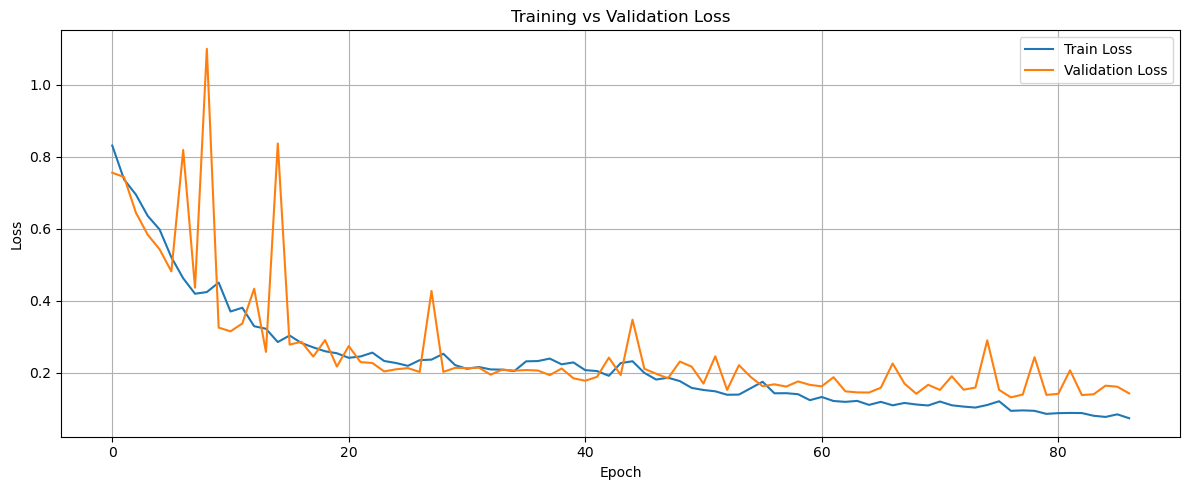

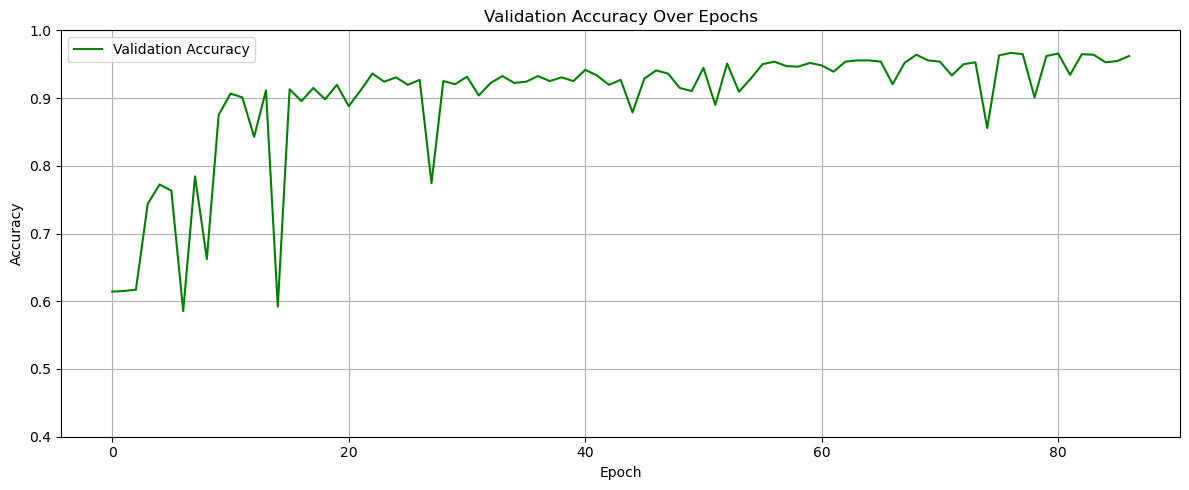

In [29]:
# --- Imports ---
import pandas as pd
import numpy as np
import os
import datetime
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score,
                             roc_curve, precision_recall_curve, average_precision_score,
                             log_loss, matthews_corrcoef, brier_score_loss)
from sklearn.calibration import calibration_curve
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit

# --- Device Setup ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🚀 Using device: {device}")

# --- Load and preprocess data ---
df = pd.read_csv('SMOTE_balanced_dataset.csv')
class_counts = df['Condition'].value_counts()
valid_classes = class_counts[class_counts > 1].index
df = df[df['Condition'].isin(valid_classes)]

X = df.drop(['Sample_ID', 'Condition'], axis=1)
y = df['Condition']

le = LabelEncoder()
y_encoded = le.fit_transform(y)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, val_index in sss.split(X_scaled, y_encoded):
    X_train, X_val = X_scaled[train_index], X_scaled[val_index]
    y_train, y_val = y_encoded[train_index], y_encoded[val_index]

torch_X_train = torch.tensor(X_train, dtype=torch.float32)
torch_y_train = torch.tensor(y_train, dtype=torch.long)
torch_X_val = torch.tensor(X_val, dtype=torch.float32)
torch_y_val = torch.tensor(y_val, dtype=torch.long)

train_dataset = TensorDataset(torch_X_train, torch_y_train)
val_dataset = TensorDataset(torch_X_val, torch_y_val)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# --- Model Definition ---
class CNN_LSTM_Model(nn.Module):
    def __init__(self, input_size, num_classes):
        super(CNN_LSTM_Model, self).__init__()
        self.conv1 = nn.Conv1d(1, 64, kernel_size=5, padding=2)
        self.bn1 = nn.BatchNorm1d(64)
        self.conv2 = nn.Conv1d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm1d(128)
        self.pool = nn.MaxPool1d(2)
        self.lstm = nn.LSTM(input_size=128, hidden_size=64, batch_first=True)
        self.fc1 = nn.Linear(64, 64)
        self.dropout = nn.Dropout(0.3)
        self.out = nn.Linear(64, num_classes)

    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.pool(torch.relu(self.bn1(self.conv1(x))))
        x = self.pool(torch.relu(self.bn2(self.conv2(x))))
        x = x.permute(0, 2, 1)
        _, (h_n, _) = self.lstm(x)
        x = torch.relu(self.fc1(h_n.squeeze(0)))
        x = self.dropout(x)
        return self.out(x)

model = CNN_LSTM_Model(input_size=X_train.shape[1], num_classes=len(np.unique(y))).to(device)

# --- Training Setup ---
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)

# --- Training Loop ---
epochs = 100
best_val_loss = float('inf')
patience, patience_counter = 10, 0
train_loss_history, val_loss_history, val_acc_history = [], [], []

now = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
save_dir = f"./results_{now}"
os.makedirs(save_dir, exist_ok=True)

for epoch in range(epochs):
    model.train()
    train_loss = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_accuracy = correct / total
    train_loss_history.append(train_loss / len(train_loader))
    val_loss_history.append(val_loss / len(val_loader))
    val_acc_history.append(val_accuracy)

    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}")

    scheduler.step(val_loss)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), os.path.join(save_dir, "best_model.pt"))
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

# --- Save Final Model ---
torch.save(model.state_dict(), os.path.join(save_dir, "cnn_lstm_model.pt"))

# --- Plot Learning Curves ---
plt.figure(figsize=(12, 5))
plt.plot(train_loss_history, label='Train Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(save_dir, 'learning_curve_updated.svg'))
plt.show()

plt.figure(figsize=(12, 5))
plt.plot(val_acc_history, label='Validation Accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy Over Epochs')
plt.ylim(0.4, 1.0)
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.savefig(os.path.join(save_dir, 'validation_accuracy_curve.svg'))
plt.show()


🚀 Using device: cuda
Epoch 1/100, Train Loss: 112.8089, Val Loss: 25.3068, Val Acc: 0.6084
Epoch 2/100, Train Loss: 99.9837, Val Loss: 24.9411, Val Acc: 0.6131
Epoch 3/100, Train Loss: 95.5397, Val Loss: 23.1231, Val Acc: 0.6236
Epoch 4/100, Train Loss: 92.1710, Val Loss: 23.2912, Val Acc: 0.6293
Epoch 5/100, Train Loss: 80.6617, Val Loss: 18.8386, Val Acc: 0.7538
Epoch 6/100, Train Loss: 71.7220, Val Loss: 16.1708, Val Acc: 0.7605
Epoch 7/100, Train Loss: 64.8856, Val Loss: 16.7952, Val Acc: 0.7576
Epoch 8/100, Train Loss: 62.1844, Val Loss: 15.3298, Val Acc: 0.7994
Epoch 9/100, Train Loss: 53.5083, Val Loss: 14.6177, Val Acc: 0.8070
Epoch 10/100, Train Loss: 51.6460, Val Loss: 10.4120, Val Acc: 0.8669
Epoch 11/100, Train Loss: 46.2490, Val Loss: 14.4513, Val Acc: 0.8422
Epoch 12/100, Train Loss: 49.4416, Val Loss: 12.9196, Val Acc: 0.8375
Epoch 13/100, Train Loss: 41.2063, Val Loss: 9.9437, Val Acc: 0.8840
Epoch 14/100, Train Loss: 42.1702, Val Loss: 8.6097, Val Acc: 0.8973
Epoch 15/

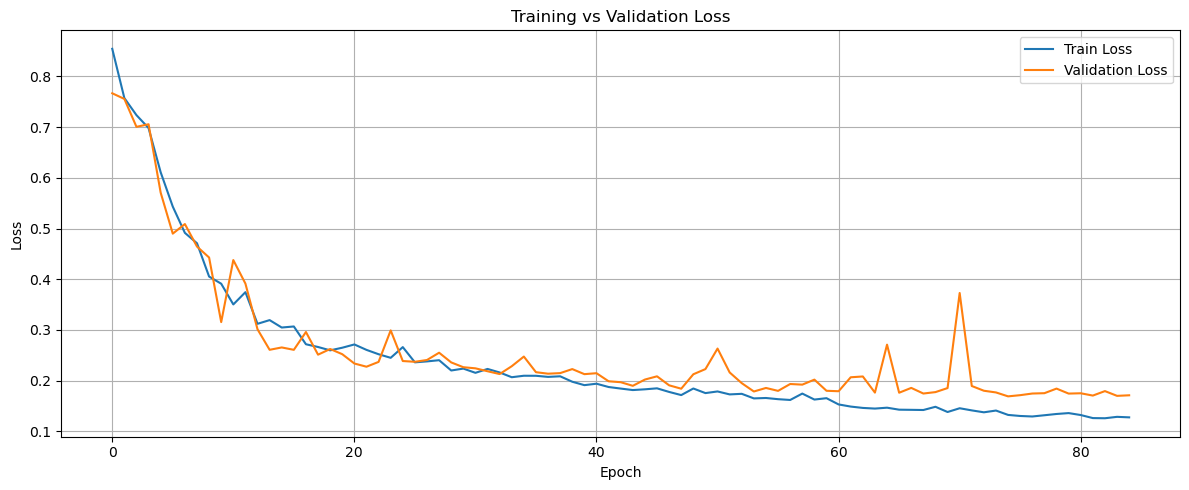

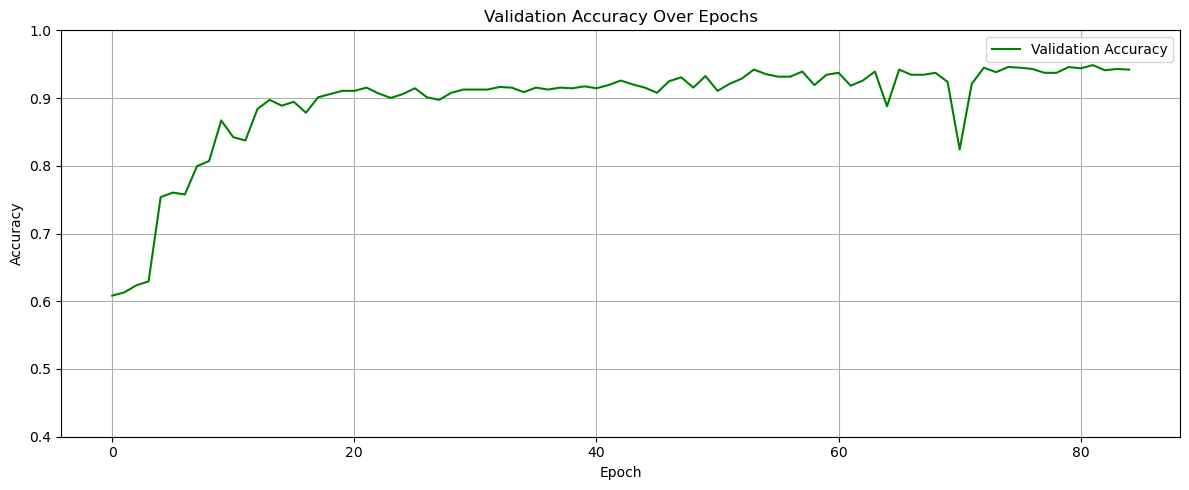

In [31]:
# --- Imports ---
import pandas as pd
import numpy as np
import os
import datetime
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score,
                             roc_curve, precision_recall_curve, average_precision_score,
                             log_loss, matthews_corrcoef, brier_score_loss)
from sklearn.calibration import calibration_curve
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit

# --- Device Setup ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🚀 Using device: {device}")

# --- Load and preprocess data ---
df = pd.read_csv('Duplicate_ nan_filled_dataset.csv')
class_counts = df['Condition'].value_counts()
valid_classes = class_counts[class_counts > 1].index
df = df[df['Condition'].isin(valid_classes)]

X = df.drop(['Sample_ID', 'Condition'], axis=1)
y = df['Condition']

le = LabelEncoder()
y_encoded = le.fit_transform(y)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, val_index in sss.split(X_scaled, y_encoded):
    X_train, X_val = X_scaled[train_index], X_scaled[val_index]
    y_train, y_val = y_encoded[train_index], y_encoded[val_index]

torch_X_train = torch.tensor(X_train, dtype=torch.float32)
torch_y_train = torch.tensor(y_train, dtype=torch.long)
torch_X_val = torch.tensor(X_val, dtype=torch.float32)
torch_y_val = torch.tensor(y_val, dtype=torch.long)

train_dataset = TensorDataset(torch_X_train, torch_y_train)
val_dataset = TensorDataset(torch_X_val, torch_y_val)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# --- Model Definition ---
class CNN_LSTM_Model(nn.Module):
    def __init__(self, input_size, num_classes):
        super(CNN_LSTM_Model, self).__init__()
        self.conv1 = nn.Conv1d(1, 64, kernel_size=5, padding=2)
        self.bn1 = nn.BatchNorm1d(64)
        self.conv2 = nn.Conv1d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm1d(128)
        self.pool = nn.MaxPool1d(2)
        self.lstm = nn.LSTM(input_size=128, hidden_size=64, batch_first=True)
        self.fc1 = nn.Linear(64, 64)
        self.dropout = nn.Dropout(0.3)
        self.out = nn.Linear(64, num_classes)

    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.pool(torch.relu(self.bn1(self.conv1(x))))
        x = self.pool(torch.relu(self.bn2(self.conv2(x))))
        x = x.permute(0, 2, 1)
        _, (h_n, _) = self.lstm(x)
        x = torch.relu(self.fc1(h_n.squeeze(0)))
        x = self.dropout(x)
        return self.out(x)

model = CNN_LSTM_Model(input_size=X_train.shape[1], num_classes=len(np.unique(y))).to(device)

# --- Training Setup ---
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)

# --- Training Loop ---
epochs = 100
best_val_loss = float('inf')
patience, patience_counter = 10, 0
train_loss_history, val_loss_history, val_acc_history = [], [], []

now = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
save_dir = f"./results_{now}"
os.makedirs(save_dir, exist_ok=True)

for epoch in range(epochs):
    model.train()
    train_loss = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_accuracy = correct / total
    train_loss_history.append(train_loss / len(train_loader))
    val_loss_history.append(val_loss / len(val_loader))
    val_acc_history.append(val_accuracy)

    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}")

    scheduler.step(val_loss)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), os.path.join(save_dir, "best_model.pt"))
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

# --- Save Final Model ---
torch.save(model.state_dict(), os.path.join(save_dir, "cnn_lstm_model.pt"))

# --- Plot Learning Curves ---
plt.figure(figsize=(12, 5))
plt.plot(train_loss_history, label='Train Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(save_dir, 'learning_curve_updated.svg'))
plt.show()

plt.figure(figsize=(12, 5))
plt.plot(val_acc_history, label='Validation Accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy Over Epochs')
plt.ylim(0.4, 1.0)
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.savefig(os.path.join(save_dir, 'validation_accuracy_curve.svg'))
plt.show()


In [42]:
pip install keras-tuner shap


Note: you may need to restart the kernel to use updated packages.


In [1]:
# --- Imports ---
import pandas as pd
import numpy as np
import os
import datetime
import shap
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
import keras_tuner as kt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🚀 Using device: {device}")

# --- Load & preprocess data ---
df = pd.read_csv('Duplicate_nan_filled_dataset.csv')
df = df[df['Condition'].isin(df['Condition'].value_counts()[lambda x: x > 1].index)]
X = df.drop(['Sample_ID', 'Condition'], axis=1)
y = df['Condition']

le = LabelEncoder()
y_encoded = le.fit_transform(y)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_idx, val_idx in sss.split(X_scaled, y_encoded):
    X_train, X_val = X_scaled[train_idx], X_scaled[val_idx]
    y_train, y_val = y_encoded[train_idx], y_encoded[val_idx]

torch_X_train = torch.tensor(X_train, dtype=torch.float32)
torch_y_train = torch.tensor(y_train, dtype=torch.long)
torch_X_val = torch.tensor(X_val, dtype=torch.float32)
torch_y_val = torch.tensor(y_val, dtype=torch.long)

train_dataset = TensorDataset(torch_X_train, torch_y_train)
val_dataset = TensorDataset(torch_X_val, torch_y_val)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# --- CNN-LSTM Model ---
class CNN_LSTM_Model(nn.Module):
    def __init__(self, input_size, num_classes, dropout_rate):
        super(CNN_LSTM_Model, self).__init__()
        self.conv1 = nn.Conv1d(1, 64, kernel_size=5, padding=2)
        self.bn1 = nn.BatchNorm1d(64)
        self.conv2 = nn.Conv1d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm1d(128)
        self.pool = nn.MaxPool1d(2)
        self.lstm = nn.LSTM(input_size=128, hidden_size=64, batch_first=True)
        self.fc1 = nn.Linear(64, 64)
        self.dropout = nn.Dropout(dropout_rate)
        self.out = nn.Linear(64, num_classes)

    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.pool(torch.relu(self.bn1(self.conv1(x))))
        x = self.pool(torch.relu(self.bn2(self.conv2(x))))
        x = x.permute(0, 2, 1)
        _, (h_n, _) = self.lstm(x)
        x = torch.relu(self.fc1(h_n.squeeze(0)))
        x = self.dropout(x)
        return self.out(x)

# --- Objective function for tuning ---
def model_builder(hp):
    lr = hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])
    dropout = hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1)
    model = CNN_LSTM_Model(input_size=X_train.shape[1], num_classes=len(np.unique(y)), dropout_rate=dropout).to(device)
    return model, lr

def train_and_eval(hp):
    model, lr = model_builder(hp)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    
    for epoch in range(10):  # Fast trial
        model.train()
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()
    return correct / total

# --- Hyperparameter tuning ---
tuner = kt.Hyperband(
    train_and_eval,
    objective="val_accuracy",
    max_epochs=10,
    directory="tuner_dir",
    project_name="cnn_lstm_tuning"
)
tuner.search_space_summary()
tuner.search()

best_hp = tuner.get_best_hyperparameters(1)[0]
print(f"✅ Best Hyperparams: LR={best_hp.get('learning_rate')}, Dropout={best_hp.get('dropout_rate')}")

# --- Train final model with best hyperparameters ---
model = CNN_LSTM_Model(input_size=X_train.shape[1], num_classes=len(np.unique(y)), dropout_rate=best_hp.get("dropout_rate")).to(device)
optimizer = optim.Adam(model.parameters(), lr=best_hp.get("learning_rate"))
criterion = nn.CrossEntropyLoss()

epochs = 30
for epoch in range(epochs):
    model.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1} complete.")

# --- SHAP Integration ---
model.eval()
background = torch_X_train[:100].unsqueeze(1).to(device)  # SHAP reference data
explainer = shap.DeepExplainer(model, background)

test_inputs = torch_X_train[:200].unsqueeze(1).to(device)
shap_values = explainer.shap_values(test_inputs)
shap_values = np.array(shap_values)[0]  # Class-0 or general

shap_avg = np.abs(shap_values).mean(axis=0).flatten()
top_100_idx = np.argsort(shap_avg)[-100:][::-1]

top_genes = pd.DataFrame({
    "Gene": X.columns[top_100_idx],
    "Importance": shap_avg[top_100_idx]
})

now = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
save_dir = f"./results_shap_{now}"
os.makedirs(save_dir, exist_ok=True)

top_genes.to_csv(os.path.join(save_dir, "top_100_shap_genes.csv"), index=False)
print(f"📄 Saved top 100 genes to: {os.path.join(save_dir, 'top_100_shap_genes.csv')}")

# Optional: Plot
plt.figure(figsize=(10, 8))
sns.barplot(data=top_genes, y="Gene", x="Importance")
plt.title("Top 100 Most Important Genes (SHAP)")
plt.tight_layout()
plt.savefig(os.path.join(save_dir, "shap_top_100_genes.svg"))
plt.show()

🚀 Using device: cuda
Search space summary
Default search space size: 2
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}
dropout_rate (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}

Search: Running Trial #1

Value             |Best Value So Far |Hyperparameter
0.001             |0.001             |learning_rate
0.1               |0.1               |dropout_rate
2                 |2                 |tuner/epochs
0                 |0                 |tuner/initial_epoch
2                 |2                 |tuner/bracket
0                 |0                 |tuner/round




FatalTypeError: Expected the model-building function, or HyperModel.build() to return a valid Keras Model instance. Received: 0.8830798479087453 of type <class 'float'>.

In [2]:
pip install optuna



   ---------------------------------------- 0.0/383.6 kB ? eta -:--:--
   ------------------------------ --------- 297.0/383.6 kB 9.0 MB/s eta 0:00:01
   ---------------------------------------- 383.6/383.6 kB 5.9 MB/s eta 0:00:00
   ---------------------------------------- 0.0/231.9 kB ? eta -:--:--
   ---------------------------------------- 231.9/231.9 kB 6.9 MB/s eta 0:00:00
   ---------------------------------------- 0.0/45.8 kB ? eta -:--:--
   ---------------------------------------- 45.8/45.8 kB ? eta 0:00:00
   ---------------------------------------- 0.0/78.5 kB ? eta -:--:--
   ---------------------------------------- 78.5/78.5 kB ? eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.11.0
    Uninstalling typing_extensions-4.11.0:
      Successfully uninstalled typing_extensions-4.11.0


In [3]:
import optuna

def objective(trial):
    lr = trial.suggest_categorical("lr", [1e-2, 1e-3, 1e-4])
    dropout_rate = trial.suggest_float("dropout", 0.1, 0.5, step=0.1)
    
    model = CNN_LSTM_Model(input_size=X_train.shape[1], num_classes=len(np.unique(y)), dropout_rate=dropout_rate).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    
    for epoch in range(10):  # quick trial run
        model.train()
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
    
    # Evaluation
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()

    accuracy = correct / total
    return accuracy

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)

print("✅ Best hyperparameters:", study.best_params)

# === Train Final Model ===
best_params = study.best_params
model = CNN_LSTM_Model(input_size=X_train.shape[1], num_classes=len(np.unique(y)), dropout_rate=best_params["dropout"]).to(device)
optimizer = optim.Adam(model.parameters(), lr=best_params["lr"])
criterion = nn.CrossEntropyLoss()

for epoch in range(30):  # longer training
    model.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}/30 complete.")

# === SHAP Integration ===
model.eval()
background = torch_X_train[:100].unsqueeze(1).to(device)
explainer = shap.DeepExplainer(model, background)

test_inputs = torch_X_train[:200].unsqueeze(1).to(device)
shap_values = explainer.shap_values(test_inputs)

# Extract and average SHAP values
shap_values = np.array(shap_values)[0]  # Assuming single-class
shap_avg = np.abs(shap_values).mean(axis=0).flatten()
top_100_idx = np.argsort(shap_avg)[-100:][::-1]

top_genes = pd.DataFrame({
    "Gene": X.columns[top_100_idx],
    "Importance": shap_avg[top_100_idx]
})

# Save Results
now = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
save_dir = f"./optuna_shap_results_{now}"
os.makedirs(save_dir, exist_ok=True)

top_genes.to_csv(os.path.join(save_dir, "top_100_shap_genes.csv"), index=False)
print(f"📄 Top 100 genes saved to: {os.path.join(save_dir, 'top_100_shap_genes.csv')}")

# Optional Plot
plt.figure(figsize=(10, 8))
sns.barplot(data=top_genes, y="Gene", x="Importance")
plt.title("Top 100 SHAP Genes")
plt.tight_layout()
plt.savefig(os.path.join(save_dir, "shap_top_100_genes.svg"))
plt.show()


[I 2025-04-13 14:09:50,507] A new study created in memory with name: no-name-f46a923a-538b-4d34-af26-076631bbbd38
[I 2025-04-13 14:10:24,175] Trial 0 finished with value: 0.8602661596958175 and parameters: {'lr': 0.0001, 'dropout': 0.30000000000000004}. Best is trial 0 with value: 0.8602661596958175.
[I 2025-04-13 14:10:58,406] Trial 1 finished with value: 0.8688212927756654 and parameters: {'lr': 0.0001, 'dropout': 0.1}. Best is trial 1 with value: 0.8688212927756654.
[I 2025-04-13 14:11:34,089] Trial 2 finished with value: 0.8669201520912547 and parameters: {'lr': 0.0001, 'dropout': 0.1}. Best is trial 1 with value: 0.8688212927756654.
[I 2025-04-13 14:12:09,759] Trial 3 finished with value: 0.905893536121673 and parameters: {'lr': 0.01, 'dropout': 0.1}. Best is trial 3 with value: 0.905893536121673.
[I 2025-04-13 14:12:45,172] Trial 4 finished with value: 0.870722433460076 and parameters: {'lr': 0.001, 'dropout': 0.5}. Best is trial 3 with value: 0.905893536121673.
[I 2025-04-13 14:

✅ Best hyperparameters: {'lr': 0.01, 'dropout': 0.1}
Epoch 1/30 complete.
Epoch 2/30 complete.
Epoch 3/30 complete.
Epoch 4/30 complete.
Epoch 5/30 complete.
Epoch 6/30 complete.
Epoch 7/30 complete.
Epoch 8/30 complete.
Epoch 9/30 complete.
Epoch 10/30 complete.
Epoch 11/30 complete.
Epoch 12/30 complete.
Epoch 13/30 complete.
Epoch 14/30 complete.
Epoch 15/30 complete.
Epoch 16/30 complete.
Epoch 17/30 complete.
Epoch 18/30 complete.
Epoch 19/30 complete.
Epoch 20/30 complete.
Epoch 21/30 complete.
Epoch 22/30 complete.
Epoch 23/30 complete.
Epoch 24/30 complete.
Epoch 25/30 complete.
Epoch 26/30 complete.
Epoch 27/30 complete.
Epoch 28/30 complete.
Epoch 29/30 complete.
Epoch 30/30 complete.


RuntimeError: Expected 2D (unbatched) or 3D (batched) input to conv1d, but got input of size: [100, 1, 1, 11519]

In [17]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectKBest, f_classif
import pandas as pd
import numpy as np
import itertools
from datetime import datetime

# --- Device Setup ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🚀 Using device: {device}")

# --- Load and preprocess data ---
df = pd.read_csv('SMOTE_balanced_dataset.csv')
df = df[df['Condition'].isin(df['Condition'].value_counts()[lambda x: x > 1].index)]

X = df.drop(['Sample_ID', 'Condition'], axis=1)
y = df['Condition']

le = LabelEncoder()
y_encoded = le.fit_transform(y)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --- Select top 5000 features ---
selector = SelectKBest(score_func=f_classif, k=5000)
X_selected = selector.fit_transform(X_scaled, y_encoded)

X_train, X_val, y_train, y_val = train_test_split(X_selected, y_encoded, test_size=0.2, random_state=42, shuffle=True)

torch_X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
torch_y_train = torch.tensor(y_train, dtype=torch.long).to(device)
torch_X_val = torch.tensor(X_val, dtype=torch.float32).to(device)
torch_y_val = torch.tensor(y_val, dtype=torch.long).to(device)

# --- Define Model ---
class GridCNN_LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, dropout1, dropout2, num_classes):
        super(GridCNN_LSTM, self).__init__()
        self.conv1 = nn.Conv1d(1, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool1d(2)
        self.lstm = nn.LSTM(input_size=32, hidden_size=hidden_size, batch_first=True)
        self.fc1 = nn.Linear(hidden_size, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.dropout1 = nn.Dropout(dropout1)
        self.fc2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.dropout2 = nn.Dropout(dropout2)
        self.out = nn.Linear(64, num_classes)

    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.pool(torch.relu(self.conv1(x)))
        x = x.permute(0, 2, 1)
        _, (h_n, _) = self.lstm(x)
        x = h_n.squeeze(0)
        x = torch.relu(self.bn1(self.fc1(x)))
        x = self.dropout1(x)
        x = torch.relu(self.bn2(self.fc2(x)))
        x = self.dropout2(x)
        return self.out(x)

# --- Grid Parameters ---
learning_rates = [0.001, 0.0005, 0.0001]
dropout1_values = [0.3, 0.4, 0.5]
dropout2_values = [0.2, 0.3, 0.4]
hidden_sizes = [64, 128]
param_grid = list(itertools.product(learning_rates, dropout1_values, dropout2_values, hidden_sizes))

# --- Grid Search ---
results = []
best_acc = 0.0
best_params = None
best_model_state = None

for lr, d1, d2, h in param_grid:
    print(f"\n🔍 Testing combo: LR={lr}, Dropout1={d1}, Dropout2={d2}, Hidden={h}")

    model = GridCNN_LSTM(input_size=X_train.shape[1], hidden_size=h, dropout1=d1, dropout2=d2,
                         num_classes=len(np.unique(y))).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_loader = DataLoader(TensorDataset(torch_X_train, torch_y_train), batch_size=32, shuffle=True)
    val_loader = DataLoader(TensorDataset(torch_X_val, torch_y_val), batch_size=32, shuffle=False)

    # Train short epochs for search
    for epoch in range(10):
        model.train()
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    # Validation
    model.eval()
    preds = []
    true_vals = []
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
            true_vals.extend(labels.cpu().numpy())

    val_acc = accuracy_score(true_vals, preds)
    print(f"✅ Val Accuracy: {val_acc:.4f}")
    results.append((lr, d1, d2, h, val_acc))

    if val_acc > best_acc:
        best_acc = val_acc
        best_params = (lr, d1, d2, h)
        best_model_state = model.state_dict()

# --- Save Best Model ---
now = datetime.now().strftime("%Y%m%d_%H%M%S")
os.makedirs("grid_search_results", exist_ok=True)
torch.save(best_model_state, f"grid_search_results/best_model_{now}.pt")
pd.DataFrame(results, columns=["lr", "dropout1", "dropout2", "hidden_size", "val_accuracy"]).to_csv(
    f"grid_search_results/grid_search_results_{now}.csv", index=False
)

print("\n🥇 Best Config:", best_params, "with accuracy:", best_acc)


🚀 Using device: cuda

🔍 Testing combo: LR=0.001, Dropout1=0.3, Dropout2=0.2, Hidden=64
✅ Val Accuracy: 0.7789

🔍 Testing combo: LR=0.001, Dropout1=0.3, Dropout2=0.2, Hidden=128
✅ Val Accuracy: 0.8538

🔍 Testing combo: LR=0.001, Dropout1=0.3, Dropout2=0.3, Hidden=64
✅ Val Accuracy: 0.7234

🔍 Testing combo: LR=0.001, Dropout1=0.3, Dropout2=0.3, Hidden=128
✅ Val Accuracy: 0.8094

🔍 Testing combo: LR=0.001, Dropout1=0.3, Dropout2=0.4, Hidden=64
✅ Val Accuracy: 0.7012

🔍 Testing combo: LR=0.001, Dropout1=0.3, Dropout2=0.4, Hidden=128
✅ Val Accuracy: 0.7882

🔍 Testing combo: LR=0.001, Dropout1=0.4, Dropout2=0.2, Hidden=64
✅ Val Accuracy: 0.6263

🔍 Testing combo: LR=0.001, Dropout1=0.4, Dropout2=0.2, Hidden=128
✅ Val Accuracy: 0.7613

🔍 Testing combo: LR=0.001, Dropout1=0.4, Dropout2=0.3, Hidden=64
✅ Val Accuracy: 0.5902

🔍 Testing combo: LR=0.001, Dropout1=0.4, Dropout2=0.3, Hidden=128
✅ Val Accuracy: 0.6078

🔍 Testing combo: LR=0.001, Dropout1=0.4, Dropout2=0.4, Hidden=64
✅ Val Accuracy: 0.

🚀 Using device: cuda
Epoch 1, Val Accuracy: 0.7224
Epoch 2, Val Accuracy: 0.7324
Epoch 3, Val Accuracy: 0.7241
Epoch 4, Val Accuracy: 0.7308
Epoch 5, Val Accuracy: 0.7308
Epoch 6, Val Accuracy: 0.7910
Epoch 7, Val Accuracy: 0.8645
Epoch 8, Val Accuracy: 0.7575
Epoch 9, Val Accuracy: 0.8829
Epoch 10, Val Accuracy: 0.9164
Epoch 11, Val Accuracy: 0.9114
Epoch 12, Val Accuracy: 0.9114
Epoch 13, Val Accuracy: 0.8696
Epoch 14, Val Accuracy: 0.8328
Epoch 15, Val Accuracy: 0.9064
Epoch 16, Val Accuracy: 0.9097
Epoch 17, Val Accuracy: 0.8696
Epoch 18, Val Accuracy: 0.8829
Epoch 19, Val Accuracy: 0.8997
Epoch 20, Val Accuracy: 0.9130
Epoch 21, Val Accuracy: 0.9164
Epoch 22, Val Accuracy: 0.8746
Epoch 23, Val Accuracy: 0.9415
Epoch 24, Val Accuracy: 0.9130
Epoch 25, Val Accuracy: 0.9331
Epoch 26, Val Accuracy: 0.9398
Epoch 27, Val Accuracy: 0.9064
Epoch 28, Val Accuracy: 0.9348
Epoch 29, Val Accuracy: 0.9331
Epoch 30, Val Accuracy: 0.8562

✅ Best Validation Accuracy: 0.9414715719063546


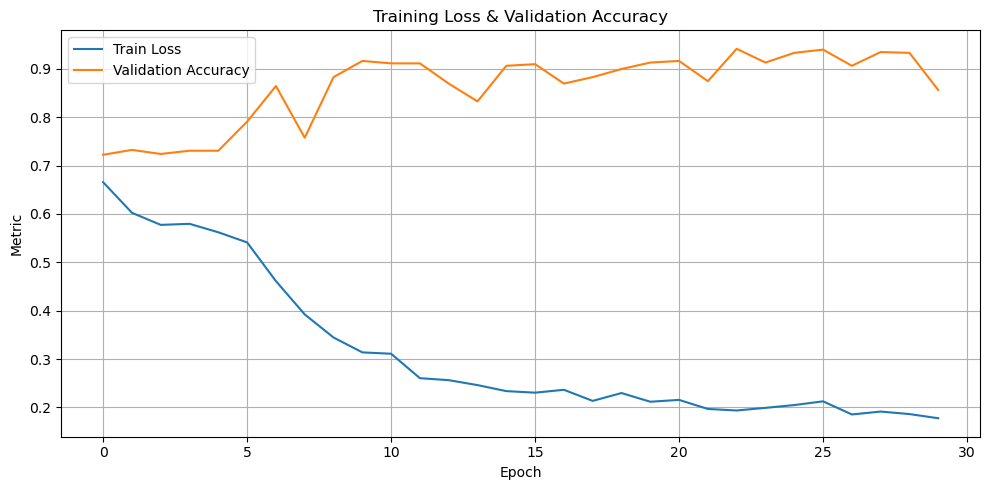

In [32]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectKBest, f_classif
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt

# --- Device Setup ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🚀 Using device: {device}")

# --- Load and preprocess data ---
df = pd.read_csv('nan_filled_dataset.csv')
df = df[df['Condition'].isin(df['Condition'].value_counts()[lambda x: x > 1].index)]

X = df.drop(['Sample_ID', 'Condition'], axis=1)
y = df['Condition']

le = LabelEncoder()
y_encoded = le.fit_transform(y)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --- Select top 3000 features ---
selector = SelectKBest(score_func=f_classif, k=3000)
X_selected = selector.fit_transform(X_scaled, y_encoded)

X_train, X_val, y_train, y_val = train_test_split(X_selected, y_encoded, test_size=0.2, random_state=42, shuffle=True)

torch_X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
torch_y_train = torch.tensor(y_train, dtype=torch.long).to(device)
torch_X_val = torch.tensor(X_val, dtype=torch.float32).to(device)
torch_y_val = torch.tensor(y_val, dtype=torch.long).to(device)

# --- Define Hybrid CNN-MLP Model ---
class HybridCNNMLP(nn.Module):
    def __init__(self, input_size, num_classes):
        super(HybridCNNMLP, self).__init__()
        self.conv1 = nn.Conv1d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm1d(32)
        self.pool = nn.MaxPool1d(2)

        conv_output_size = (input_size // 2) * 32

        self.fc_layers = nn.Sequential(
            nn.Linear(conv_output_size, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.4),

            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = x.unsqueeze(1)  # [batch, 1, features]
        x = self.pool(torch.relu(self.bn1(self.conv1(x))))
        x = x.view(x.size(0), -1)  # flatten for MLP
        return self.fc_layers(x)

# --- Initialize Model ---
model = HybridCNNMLP(input_size=X_train.shape[1], num_classes=len(np.unique(y))).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_loader = DataLoader(TensorDataset(torch_X_train, torch_y_train), batch_size=32, shuffle=True)
val_loader = DataLoader(TensorDataset(torch_X_val, torch_y_val), batch_size=32, shuffle=False)

# --- Training ---
epochs = 30
best_val_acc = 0.0
save_dir = "final_model_result"
os.makedirs(save_dir, exist_ok=True)

train_losses, val_accuracies = [], []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_losses.append(running_loss / len(train_loader))

    # Validation
    model.eval()
    preds = []
    true_vals = []
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
            true_vals.extend(labels.cpu().numpy())

    val_acc = accuracy_score(true_vals, preds)
    val_accuracies.append(val_acc)
    print(f"Epoch {epoch+1}, Val Accuracy: {val_acc:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), os.path.join(save_dir, "best_model.pt"))

print("\n✅ Best Validation Accuracy:", best_val_acc)

# --- Plot Learning Curves ---
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Metric')
plt.title('Training Loss & Validation Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(save_dir, 'learning_curves.png'))
plt.show()

# Balancing dataset

In [36]:
import pandas as pd
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler

# Load your gene expression dataset
df = pd.read_csv('nan_filled_dataset.csv')

# Split the dataset into features (X) and target (y)
X = df.drop(columns=['Sample_ID', 'Condition'])  # Drop Sample_Id and Condition columns
y = df['Condition']

# 1. SMOTE for oversampling the minority class
smote = SMOTE(sampling_strategy='auto', random_state=42)  # You can change strategy to a fixed number if desired

# Apply SMOTE to balance the dataset
X_resampled, y_resampled = smote.fit_resample(X, y)

# Combine the resampled features and target back into a DataFrame
df_resampled = pd.DataFrame(X_resampled, columns=X.columns)
df_resampled['Condition'] = y_resampled

# Optionally, add the 'Sample_Id' column if needed (can be randomly generated or retained if original Sample_Id was important)
df_resampled['Sample_Id'] = ['s'+str(i) for i in range(1, len(df_resampled) + 1)]

# Save the balanced dataset to a CSV file
df_resampled.to_csv('balanced_gene_expression_data.csv', index=False)

print("Balanced dataset saved to 'balanced_gene_expression_data.csv'")


C:\Users\Shafiya\AppData\Local\Temp\ipykernel_25004\2111031720.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_resampled['Condition'] = y_resampled
C:\Users\Shafiya\AppData\Local\Temp\ipykernel_25004\2111031720.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_resampled['Sample_Id'] = ['s'+str(i) for i in range(1, len(df_resampled) + 1)]


Balanced dataset saved to 'balanced_gene_expression_data.csv'


In [40]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder

# --- Device Setup ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🚀 Using device: {device}")

# Load your gene expression dataset
df = pd.read_csv('nan_filled_dataset.csv')

# Split the dataset into features (X) and target (y)
X = df.drop(columns=['Sample_ID', 'Condition'])  # Drop Sample_ID and Condition columns
y = df['Condition']

# Only keep the minority class (for example, "N" is the minority class)
minority_class = 'N'
X_minority = X[y == minority_class]
y_minority = y[y == minority_class]

# Encode target labels as numeric values
label_encoder = LabelEncoder()
y_minority_encoded = label_encoder.fit_transform(y_minority)

# Standardize the data
scaler = StandardScaler()
X_minority_scaled = scaler.fit_transform(X_minority)

# Convert data to PyTorch tensors
X_minority_tensor = torch.tensor(X_minority_scaled, dtype=torch.float32).to(device)
y_minority_tensor = torch.tensor(y_minority_encoded, dtype=torch.float32).to(device)  # Now it's numeric

# --- Define the GAN Models ---

# Generator
class Generator(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 256)
        self.fc3 = nn.Linear(256, 512)
        self.fc4 = nn.Linear(512, output_dim)
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()

    def forward(self, z):
        x = self.relu(self.fc1(z))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.tanh(self.fc4(x))
        return x

# Discriminator
class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(input_dim, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.sigmoid(self.fc4(x))
        return x

# --- Initialize Models ---
input_dim = X_minority_tensor.shape[1]  # Number of features in the minority class dataset
latent_dim = 100  # Dimension of random noise

generator = Generator(latent_dim, input_dim).to(device)
discriminator = Discriminator(input_dim).to(device)

# --- Loss and Optimizers ---
adversarial_loss = nn.BCELoss()
optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

# --- Training the GAN ---
def train_gan(generator, discriminator, optimizer_G, optimizer_D, adversarial_loss, X_minority_tensor, epochs=10000, batch_size=64, sample_interval=1000):
    half_batch = batch_size // 2
    for epoch in range(epochs):
        # Train discriminator
        idx = torch.randint(0, X_minority_tensor.size(0), (half_batch,))
        real_samples = X_minority_tensor[idx]
        real_labels = torch.ones(half_batch, 1).to(device)

        noise = torch.randn(half_batch, latent_dim).to(device)
        fake_samples = generator(noise)
        fake_labels = torch.zeros(half_batch, 1).to(device)

        # Discriminator loss
        optimizer_D.zero_grad()
        real_loss = adversarial_loss(discriminator(real_samples), real_labels)
        fake_loss = adversarial_loss(discriminator(fake_samples.detach()), fake_labels)
        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        optimizer_D.step()

        # Train generator
        optimizer_G.zero_grad()
        g_loss = adversarial_loss(discriminator(fake_samples), real_labels)
        g_loss.backward()
        optimizer_G.step()

        # Print the progress
        if epoch % sample_interval == 0:
            print(f"{epoch} [D loss: {d_loss.item()}] [G loss: {g_loss.item()}]")

# Train the GAN
train_gan(generator, discriminator, optimizer_G, optimizer_D, adversarial_loss, X_minority_tensor)

# --- Generate Synthetic Data ---
num_synthetic_samples = 1000  # Number of synthetic samples you want to generate
noise = torch.randn(num_synthetic_samples, latent_dim).to(device)
synthetic_samples = generator(noise)

# --- Convert to NumPy and Rescale ---
synthetic_samples_rescaled = synthetic_samples.detach().cpu().numpy()
synthetic_samples_rescaled = scaler.inverse_transform(synthetic_samples_rescaled)

# --- Decode the labels back to the original categorical values ---
# Since synthetic data is for the minority class, we set the condition as the original class 'N'
synthetic_df = pd.DataFrame(synthetic_samples_rescaled, columns=X_minority.columns)
synthetic_df['Condition'] = label_encoder.inverse_transform(np.zeros(num_synthetic_samples, dtype=int))  # Set to "N"

# --- Combine Original and Synthetic Data ---
df_balanced = pd.concat([df, synthetic_df], ignore_index=True)

# Save the balanced dataset to a CSV file
df_balanced.to_csv('balanced_gene_expression_data_with_GAN_pytorch.csv', index=False)

print("Balanced dataset saved to 'balanced_gene_expression_data_with_GAN_pytorch.csv'")


🚀 Using device: cuda
0 [D loss: 0.6942186951637268] [G loss: 0.6595738530158997]
1000 [D loss: 11.408390045166016] [G loss: 1.2051045894622803]
2000 [D loss: 10.022122383117676] [G loss: 1.1078416109085083]
3000 [D loss: 22.192092895507812] [G loss: 1.4485692977905273]
4000 [D loss: 8.32939624786377] [G loss: 1.0449481010437012]
5000 [D loss: 17.69953727722168] [G loss: 1.122322678565979]
6000 [D loss: 12.979372024536133] [G loss: 1.339053988456726]
7000 [D loss: 14.506428718566895] [G loss: 1.0797123908996582]
8000 [D loss: 14.583052635192871] [G loss: 1.042776346206665]
9000 [D loss: 17.688451766967773] [G loss: 1.1798155307769775]
Balanced dataset saved to 'balanced_gene_expression_data_with_GAN_pytorch.csv'


# Model


## PCA+CNN,LSTM

🚀 Using device: cuda
Epoch [1/50] Train Loss: 0.0147 Train Accuracy: 51.58% | Test Loss: 0.0132 Test Accuracy: 58.59%
Epoch [2/50] Train Loss: 0.0119 Train Accuracy: 62.65% | Test Loss: 0.0130 Test Accuracy: 57.52%
Epoch [3/50] Train Loss: 0.0111 Train Accuracy: 63.45% | Test Loss: 0.0120 Test Accuracy: 59.31%
Epoch [4/50] Train Loss: 0.0109 Train Accuracy: 63.54% | Test Loss: 0.0119 Test Accuracy: 59.19%
Epoch [5/50] Train Loss: 0.0108 Train Accuracy: 63.48% | Test Loss: 0.0120 Test Accuracy: 59.19%
Epoch [6/50] Train Loss: 0.0104 Train Accuracy: 63.10% | Test Loss: 0.0115 Test Accuracy: 60.02%
Epoch [7/50] Train Loss: 0.0102 Train Accuracy: 63.16% | Test Loss: 0.0112 Test Accuracy: 58.35%
Epoch [8/50] Train Loss: 0.0100 Train Accuracy: 64.38% | Test Loss: 0.0107 Test Accuracy: 65.63%
Epoch [9/50] Train Loss: 0.0090 Train Accuracy: 72.20% | Test Loss: 0.0090 Test Accuracy: 69.69%
Epoch [10/50] Train Loss: 0.0071 Train Accuracy: 80.01% | Test Loss: 0.0066 Test Accuracy: 80.19%
Epoch [1

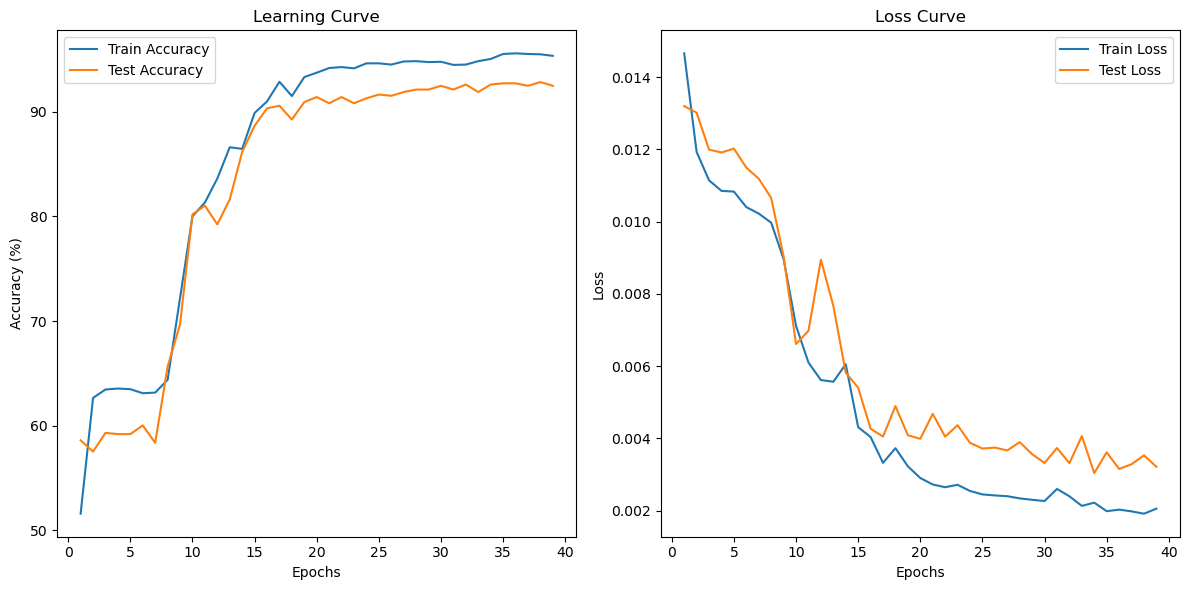

In [49]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# --- Device Setup ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🚀 Using device: {device}")

# Load your gene expression dataset
df = pd.read_csv('SMOTE_unbaisedBalance.csv')

# Split the dataset into features (X) and target (y)
X = df.drop(columns=['Sample_ID', 'Condition'])  # Drop Sample_ID and Condition columns
y = df['Condition']

# Encode target labels as numeric values
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --- Apply PCA to reduce to 3000 features ---
pca = PCA(n_components=3000)  # Preserving top 3000 features
X_pca = pca.fit_transform(X_scaled)

# Convert data to PyTorch tensors
X_tensor = torch.tensor(X_pca, dtype=torch.float32).to(device)
y_tensor = torch.tensor(y_encoded, dtype=torch.long).to(device)

# --- Train-Test Split ---
X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)

# --- CNN + LSTM Hybrid Model ---
class CNN_LSTM_Model(nn.Module):
    def __init__(self, input_dim, num_classes, lstm_hidden_dim=128, lstm_layers=2, cnn_filters=64):
        super(CNN_LSTM_Model, self).__init__()
        
        # CNN layers
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=cnn_filters, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(in_channels=cnn_filters, out_channels=cnn_filters*2, kernel_size=3, padding=1)
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)

        # LSTM layer
        self.lstm = nn.LSTM(input_size=cnn_filters*2, hidden_size=lstm_hidden_dim, num_layers=lstm_layers, batch_first=True)

        # Fully Connected layer for classification
        self.fc = nn.Linear(lstm_hidden_dim, num_classes)
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
    
    def forward(self, x):
        # Add channel dimension (batch_size, 1, features)
        x = x.unsqueeze(1)  # Shape: (batch_size, 1, input_dim)

        # CNN layers
        x = self.relu(self.conv1(x))
        x = self.pool(self.relu(self.conv2(x)))
        
        # Flatten the output from CNN and reshape for LSTM
        x = x.view(x.size(0), x.size(2), -1)  # Shape: (batch_size, seq_length, feature_dim)

        # LSTM layers
        x, _ = self.lstm(x)  # We don't need the hidden state for classification
        
        # Use the output of the last LSTM timestep
        x = x[:, -1, :]  # Shape: (batch_size, lstm_hidden_dim)

        # Fully connected layer for classification
        x = self.dropout(self.relu(x))
        x = self.fc(x)
        
        return x

# --- Initialize the Model with the Best Hyperparameters ---
cnn_filters = 64
lstm_hidden_dim = 128
lstm_layers = 2
learning_rate = 0.001

model = CNN_LSTM_Model(input_dim=X_train.size(1), num_classes=len(label_encoder.classes_),
                       lstm_hidden_dim=lstm_hidden_dim, lstm_layers=lstm_layers,
                       cnn_filters=cnn_filters).to(device)

# --- Loss and Optimizers ---
criterion = nn.CrossEntropyLoss()  # For multi-class classification
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# --- Early Stopping Setup ---
patience = 5  # Number of epochs to wait for improvement
best_val_loss = float('inf')
patience_counter = 0

# --- Training the Model ---
num_epochs = 50
batch_size = 64
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_preds = 0
    total_preds = 0
    for i in range(0, len(X_train), batch_size):
        inputs = X_train[i:i+batch_size]
        labels = y_train[i:i+batch_size]
        
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Backward pass
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        total_preds += labels.size(0)
        correct_preds += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(X_train)
    epoch_accuracy = 100 * correct_preds / total_preds

    # Validation (on test set)
    model.eval()
    test_loss = 0.0
    correct_preds_test = 0
    total_preds_test = 0
    with torch.no_grad():
        for i in range(0, len(X_test), batch_size):
            inputs_test = X_test[i:i+batch_size]
            labels_test = y_test[i:i+batch_size]
            
            outputs_test = model(inputs_test)
            loss_test = criterion(outputs_test, labels_test)
            test_loss += loss_test.item()

            _, predicted_test = torch.max(outputs_test, 1)
            total_preds_test += labels_test.size(0)
            correct_preds_test += (predicted_test == labels_test).sum().item()

    test_loss = test_loss / len(X_test)
    test_accuracy = 100 * correct_preds_test / total_preds_test

    # Store losses and accuracies
    train_losses.append(epoch_loss)
    test_losses.append(test_loss)
    train_accuracies.append(epoch_accuracy)
    test_accuracies.append(test_accuracy)

    # Print the progress
    print(f"Epoch [{epoch+1}/{num_epochs}] Train Loss: {epoch_loss:.4f} Train Accuracy: {epoch_accuracy:.2f}% | Test Loss: {test_loss:.4f} Test Accuracy: {test_accuracy:.2f}%")

    # Early stopping
    if test_loss < best_val_loss:
        best_val_loss = test_loss
        patience_counter = 0  # Reset patience counter
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

# --- Plotting Learning Curves and Loss Curves ---
# Learning curve (Accuracy)
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, len(test_accuracies) + 1), test_accuracies, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Learning Curve')
plt.legend()

# Loss curve
plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
plt.plot(range(1, len(test_losses) + 1), test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()

plt.tight_layout()
plt.show()


# Fianl fianl


🚀 Using device: cuda
Epoch [1/50] Train Loss: 0.0106 Train Accuracy: 68.20% | Test Loss: 0.0084 Test Accuracy: 88.50%
Epoch [2/50] Train Loss: 0.0069 Train Accuracy: 82.37% | Test Loss: 0.0055 Test Accuracy: 92.68%
Epoch [3/50] Train Loss: 0.0047 Train Accuracy: 90.99% | Test Loss: 0.0040 Test Accuracy: 93.82%
Epoch [4/50] Train Loss: 0.0037 Train Accuracy: 93.11% | Test Loss: 0.0033 Test Accuracy: 94.77%
Epoch [5/50] Train Loss: 0.0030 Train Accuracy: 94.44% | Test Loss: 0.0030 Test Accuracy: 95.06%
Epoch [6/50] Train Loss: 0.0027 Train Accuracy: 94.80% | Test Loss: 0.0026 Test Accuracy: 95.06%
Epoch [7/50] Train Loss: 0.0026 Train Accuracy: 95.15% | Test Loss: 0.0025 Test Accuracy: 95.25%
Epoch [8/50] Train Loss: 0.0023 Train Accuracy: 95.51% | Test Loss: 0.0024 Test Accuracy: 95.63%
Epoch [9/50] Train Loss: 0.0022 Train Accuracy: 95.72% | Test Loss: 0.0023 Test Accuracy: 95.44%
Epoch [10/50] Train Loss: 0.0019 Train Accuracy: 96.39% | Test Loss: 0.0021 Test Accuracy: 95.72%
Epoch [1

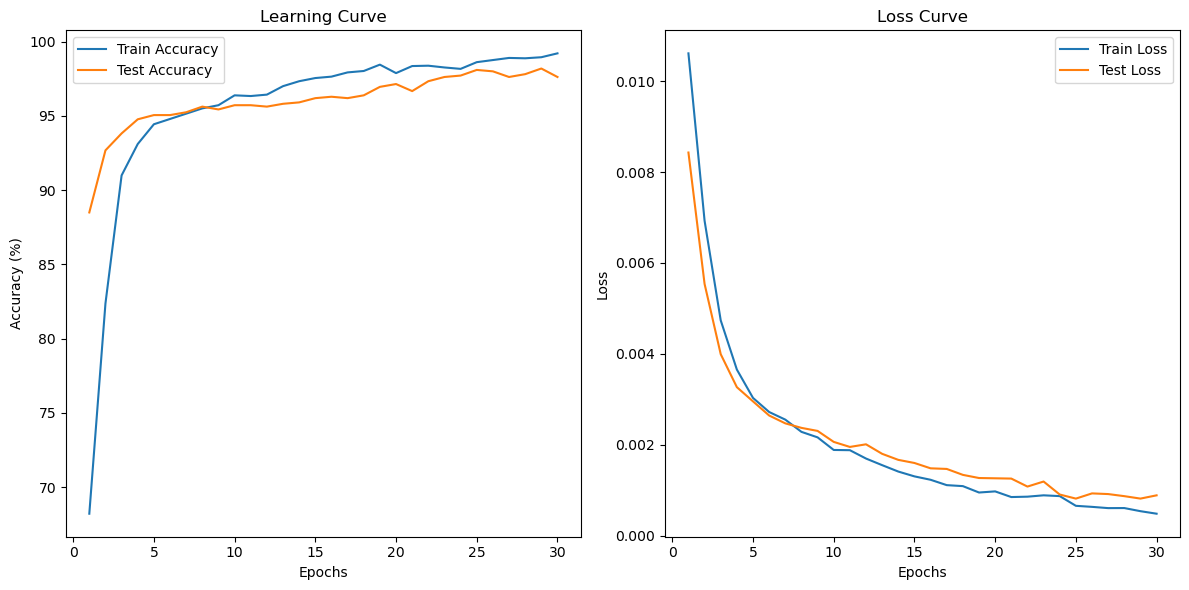

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# --- Device Setup ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🚀 Using device: {device}")

# Load your gene expression dataset
df = pd.read_csv('Duplicate_nan_filled_dataset.csv')

# Split the dataset into features (X) and target (y)
X = df.drop(columns=['Sample_ID', 'Condition'])  # Drop Sample_ID and Condition columns
y = df['Condition']

# Encode target labels as numeric values
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --- Apply PCA to reduce to 3000 features ---
pca = PCA(n_components=3000)  # Preserving top 3000 features
X_pca = pca.fit_transform(X_scaled)

# Convert data to PyTorch tensors
X_tensor = torch.tensor(X_pca, dtype=torch.float32).to(device)
y_tensor = torch.tensor(y_encoded, dtype=torch.long).to(device)

# --- Train-Test Split ---
X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)

# --- Simple CNN Model ---
class CNN_Model(nn.Module):
    def __init__(self, input_dim, num_classes, cnn_filters=64):
        super(CNN_Model, self).__init__()
        
        # CNN layers
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=cnn_filters, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(in_channels=cnn_filters, out_channels=cnn_filters*2, kernel_size=3, padding=1)
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        
        # Fully connected layer for classification
        self.fc1 = nn.Linear(cnn_filters*2 * (input_dim // 2), 128)  # Flattened size after pooling
        self.fc2 = nn.Linear(128, num_classes)
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
    
    def forward(self, x):
        # Add channel dimension (batch_size, 1, features)
        x = x.unsqueeze(1)  # Shape: (batch_size, 1, input_dim)

        # CNN layers
        x = self.relu(self.conv1(x))
        x = self.pool(self.relu(self.conv2(x)))
        
        # Flatten the output for fully connected layer
        x = x.view(x.size(0), -1)  # Flatten
        
        # Fully connected layers
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.fc2(x)
        
        return x

# --- Initialize Model ---
input_dim = X_train.size(1)  # Number of features after PCA
num_classes = len(label_encoder.classes_)

model = CNN_Model(input_dim=input_dim, num_classes=num_classes).to(device)

# --- Loss and Optimizers ---
criterion = nn.CrossEntropyLoss()  # For multi-class classification
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# --- Early Stopping Setup ---
patience = 5  # Number of epochs to wait for improvement
best_val_loss = float('inf')
patience_counter = 0

# --- Training the Model ---
num_epochs = 50
batch_size = 64
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_preds = 0
    total_preds = 0
    for i in range(0, len(X_train), batch_size):
        inputs = X_train[i:i+batch_size]
        labels = y_train[i:i+batch_size]
        
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Backward pass
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        total_preds += labels.size(0)
        correct_preds += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(X_train)
    epoch_accuracy = 100 * correct_preds / total_preds

    # Validation (on test set)
    model.eval()
    test_loss = 0.0
    correct_preds_test = 0
    total_preds_test = 0
    with torch.no_grad():
        for i in range(0, len(X_test), batch_size):
            inputs_test = X_test[i:i+batch_size]
            labels_test = y_test[i:i+batch_size]
            
            outputs_test = model(inputs_test)
            loss_test = criterion(outputs_test, labels_test)
            test_loss += loss_test.item()

            _, predicted_test = torch.max(outputs_test, 1)
            total_preds_test += labels_test.size(0)
            correct_preds_test += (predicted_test == labels_test).sum().item()

    test_loss = test_loss / len(X_test)
    test_accuracy = 100 * correct_preds_test / total_preds_test

    # Store losses and accuracies
    train_losses.append(epoch_loss)
    test_losses.append(test_loss)
    train_accuracies.append(epoch_accuracy)
    test_accuracies.append(test_accuracy)

    # Print the progress
    print(f"Epoch [{epoch+1}/{num_epochs}] Train Loss: {epoch_loss:.4f} Train Accuracy: {epoch_accuracy:.2f}% | Test Loss: {test_loss:.4f} Test Accuracy: {test_accuracy:.2f}%")

    # Early stopping
    if test_loss < best_val_loss:
        best_val_loss = test_loss
        patience_counter = 0  # Reset patience counter
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

# --- Plotting Learning Curves and Loss Curves ---
# Learning curve (Accuracy)
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, len(test_accuracies) + 1), test_accuracies, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Learning Curve')
plt.legend()

# Loss curve
plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
plt.plot(range(1, len(test_losses) + 1), test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()

plt.tight_layout()
plt.show()


🚀 Using device: cuda
Epoch [1/50] Train Loss: 0.0119 Train Accuracy: 62.48% | Test Loss: 0.0100 Test Accuracy: 71.48%
Epoch [2/50] Train Loss: 0.0090 Train Accuracy: 73.48% | Test Loss: 0.0080 Test Accuracy: 89.83%
Epoch [3/50] Train Loss: 0.0072 Train Accuracy: 82.77% | Test Loss: 0.0061 Test Accuracy: 92.78%
Epoch [4/50] Train Loss: 0.0055 Train Accuracy: 88.88% | Test Loss: 0.0046 Test Accuracy: 93.35%
Epoch [5/50] Train Loss: 0.0042 Train Accuracy: 92.28% | Test Loss: 0.0037 Test Accuracy: 93.92%
Epoch [6/50] Train Loss: 0.0035 Train Accuracy: 93.80% | Test Loss: 0.0032 Test Accuracy: 94.58%
Epoch [7/50] Train Loss: 0.0031 Train Accuracy: 94.23% | Test Loss: 0.0029 Test Accuracy: 94.77%
Epoch [8/50] Train Loss: 0.0028 Train Accuracy: 94.75% | Test Loss: 0.0027 Test Accuracy: 95.15%
Epoch [9/50] Train Loss: 0.0026 Train Accuracy: 95.10% | Test Loss: 0.0025 Test Accuracy: 95.44%
Epoch [10/50] Train Loss: 0.0024 Train Accuracy: 95.20% | Test Loss: 0.0023 Test Accuracy: 95.44%
Epoch [1

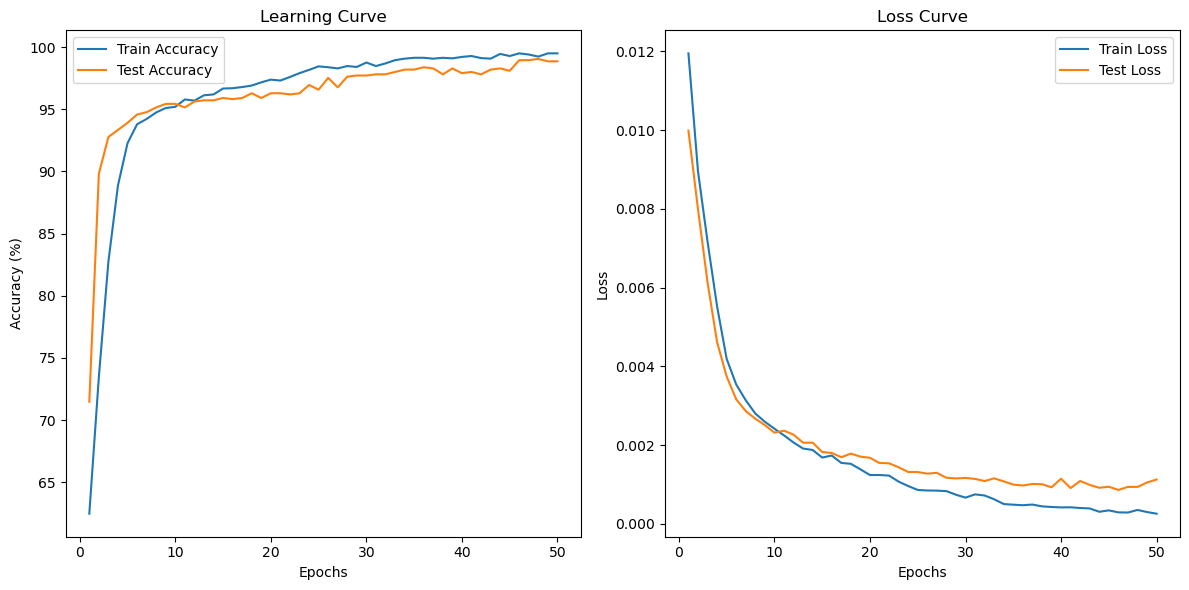

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os
import random
import shap

# --- Set Random Seed for Reproducibility ---
def set_seed(seed=42):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Set seed
set_seed(42)

# --- Device Setup ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🚀 Using device: {device}")

# Load your gene expression dataset
df = pd.read_csv('Duplicate_nan_filled_dataset.csv')

# Split the dataset into features (X) and target (y)
X = df.drop(columns=['Sample_ID', 'Condition'])  # Drop Sample_ID and Condition columns
y = df['Condition']

# Encode target labels as numeric values
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --- Apply PCA to reduce to 3000 features ---
pca = PCA(n_components=3000)  # Preserving top 3000 features
X_pca = pca.fit_transform(X_scaled)

# Convert data to PyTorch tensors
X_tensor = torch.tensor(X_pca, dtype=torch.float32).to(device)
y_tensor = torch.tensor(y_encoded, dtype=torch.long).to(device)

# --- Train-Test Split ---
X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)

# --- Simple CNN Model ---
class CNN_Model(nn.Module):
    def __init__(self, input_dim, num_classes, cnn_filters=64):
        super(CNN_Model, self).__init__()

        # CNN layers
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=cnn_filters, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(in_channels=cnn_filters, out_channels=cnn_filters*2, kernel_size=3, padding=1)
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)

        # Fully connected layer for classification
        self.fc1 = nn.Linear(cnn_filters*2 * (input_dim // 2), 128)  # Flattened size after pooling
        self.fc2 = nn.Linear(128, num_classes)

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        # Add channel dimension (batch_size, 1, features)
        x = x.unsqueeze(1)  # Shape: (batch_size, 1, input_dim)

        # CNN layers
        x = self.relu(self.conv1(x))
        x = self.pool(self.relu(self.conv2(x)))

        # Flatten the output for fully connected layer
        x = x.view(x.size(0), -1)  # Flatten

        # Fully connected layers
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.fc2(x)

        return x

# --- Initialize Model ---
input_dim = X_train.size(1)  # Number of features after PCA
num_classes = len(label_encoder.classes_)

model = CNN_Model(input_dim=input_dim, num_classes=num_classes).to(device)

# --- Loss and Optimizers ---
criterion = nn.CrossEntropyLoss()  # For multi-class classification
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# --- Early Stopping Setup ---
patience = 5  # Number of epochs to wait for improvement
best_val_loss = float('inf')
patience_counter = 0

# --- Save History ---
history = {
    'train_losses': [],
    'test_losses': [],
    'train_accuracies': [],
    'test_accuracies': []
}

# --- Training the Model ---
num_epochs = 50
batch_size = 64

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_preds = 0
    total_preds = 0
    for i in range(0, len(X_train), batch_size):
        inputs = X_train[i:i+batch_size]
        labels = y_train[i:i+batch_size]

        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        total_preds += labels.size(0)
        correct_preds += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(X_train)
    epoch_accuracy = 100 * correct_preds / total_preds

    # Validation (on test set)
    model.eval()
    test_loss = 0.0
    correct_preds_test = 0
    total_preds_test = 0
    with torch.no_grad():
        for i in range(0, len(X_test), batch_size):
            inputs_test = X_test[i:i+batch_size]
            labels_test = y_test[i:i+batch_size]

            outputs_test = model(inputs_test)
            loss_test = criterion(outputs_test, labels_test)
            test_loss += loss_test.item()

            _, predicted_test = torch.max(outputs_test, 1)
            total_preds_test += labels_test.size(0)
            correct_preds_test += (predicted_test == labels_test).sum().item()

    test_loss = test_loss / len(X_test)
    test_accuracy = 100 * correct_preds_test / total_preds_test

    # Store losses and accuracies in history
    history['train_losses'].append(epoch_loss)
    history['test_losses'].append(test_loss)
    history['train_accuracies'].append(epoch_accuracy)
    history['test_accuracies'].append(test_accuracy)

    # Print the progress
    print(f"Epoch [{epoch+1}/{num_epochs}] Train Loss: {epoch_loss:.4f} Train Accuracy: {epoch_accuracy:.2f}% | Test Loss: {test_loss:.4f} Test Accuracy: {test_accuracy:.2f}%")

    # Early stopping
    if test_loss < best_val_loss:
        best_val_loss = test_loss
        patience_counter = 0  # Reset patience counter
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

# --- Save the Model and History ---
# Save the model weights
torch.save(model.state_dict(), "cnn_model.pth")

# Save the training history (losses and accuracies)
history_df = pd.DataFrame(history)
history_df.to_csv("model_history.csv", index=False)

# --- Plotting Learning Curves and Loss Curves ---
# Learning curve (Accuracy)
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(history['train_accuracies']) + 1), history['train_accuracies'], label='Train Accuracy')
plt.plot(range(1, len(history['test_accuracies']) + 1), history['test_accuracies'], label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Learning Curve')
plt.legend()

# Loss curve
plt.subplot(1, 2, 2)
plt.plot(range(1, len(history['train_losses']) + 1), history['train_losses'], label='Train Loss')
plt.plot(range(1, len(history['test_losses']) + 1), history['test_losses'], label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()

plt.tight_layout()
plt.show()




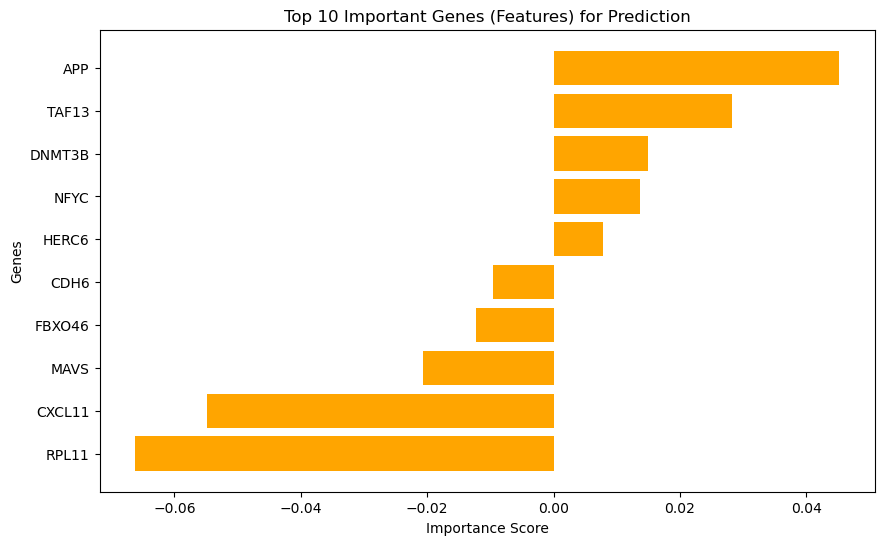

In [15]:
import lime
import lime.lime_tabular
import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt

# Function to convert your model's output to probabilities for LIME
def model_predict(input_data):
    # Convert input data (which is a NumPy array) into a PyTorch tensor
    input_tensor = torch.tensor(input_data, dtype=torch.float32).to(device)
    
    # Ensure model is in evaluation mode
    model.eval()
    
    # Perform a forward pass through the CNN model (output is raw logits)
    with torch.no_grad():
        outputs = model(input_tensor)
    
    # Apply softmax to get probabilities for each class
    return torch.softmax(outputs, dim=1).cpu().detach().numpy()  # Return as numpy array

# Convert PyTorch tensors to NumPy arrays for LIME
X_train_np = X_train.cpu().numpy()  # Ensure X_train is on CPU and converted to numpy array
X_test_np = X_test.cpu().numpy()    # Ensure X_test is on CPU and converted to numpy array
y_train_np = y_train.cpu().numpy()  # Ensure y_train is on CPU and converted to numpy array

# Initialize LIME Explainer
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train_np,  # Your training data as a numpy array
    training_labels=y_train_np,  # Your target labels as a numpy array
    mode="classification",  # For classification tasks
    class_names=label_encoder.classes_,  # Class names from label encoder
    discretize_continuous=True  # Discretize continuous features if needed
)

# --- Choose a sample to explain ---
sample_index = 0  # Choose a test sample (change the index to select a different one)
sample = X_test_np[sample_index]  # Sample to explain (as numpy array)

# Explain the model's prediction for this particular sample
explanation = explainer.explain_instance(sample, model_predict)

# Get feature names (the gene names) from your dataset
feature_names = df.drop(columns=['Sample_ID', 'Condition']).columns.tolist()

# Get the feature importances from the explanation object
importance_scores = explanation.as_list()

# Convert the feature names and importance scores into a DataFrame
importance_df = pd.DataFrame(importance_scores, columns=["Feature", "Importance"])

# Function to clean the feature names and exclude non-valid features like 'FALSE'
def clean_feature_name(feature):
    # Check if feature is a valid feature (not 'FALSE' or non-numeric value)
    try:
        feature_number = float(feature.split()[0])  # Cleanly parse the numeric part
        return int(feature_number)  # Return the integer index of the feature
    except ValueError:
        return None  # If the feature cannot be converted to a valid number, return None

# Apply the cleaning function to the 'Feature' column
importance_df["Cleaned_Feature"] = importance_df["Feature"].apply(clean_feature_name)

# Drop rows with 'None' values in the Cleaned_Feature column
importance_df = importance_df.dropna(subset=["Cleaned_Feature"])

# Map the cleaned feature numbers to the actual gene names
importance_df["Gene"] = importance_df["Cleaned_Feature"].apply(
    lambda x: feature_names[x - 1]  # Adjusting for 0-based indexing
)

# Sort the DataFrame by importance score in descending order
importance_df = importance_df.sort_values(by="Importance", ascending=False)

# --- Visualize Top 20 Genes --- 
top_20_genes = importance_df.head(20)  # Get the top 20 genes based on importance

plt.figure(figsize=(10, 6))
plt.barh(top_20_genes["Gene"], top_20_genes["Importance"], color='orange')
plt.xlabel('Importance Score')
plt.ylabel('Genes')
plt.title('Top 10 Important Genes (Features) for Prediction')
plt.gca().invert_yaxis()  # Invert y-axis to show the highest importance at the top

# Save the plot as SVG with 300 DPI
plt.savefig("top_10_genes_importance.svg", format='svg', dpi=300)

# Show the plot
plt.show()

# --- Save Top 500 Genes with their Importance Scores to CSV ---
top_500_genes = importance_df.head(500)  # Select the top 500 genes based on importance scores
top_500_genes.to_csv("top_500_genes_importance.csv", index=False)


                Feature  Importance  Cleaned_Feature    Gene
1              6 > 0.77    0.049578                6     APP
3              5 > 0.81    0.041914                5   TAF13
4           65 <= -0.18    0.018124               65    PKN1
5           1481 > 0.02    0.013062             1481    CLK4
6           1710 > 0.01    0.010659             1710   USP36
9          719 <= -0.04   -0.008860              719   RPS10
8  -0.00 < 2969 <= 0.00   -0.010321                0    MAVS
7          625 <= -0.07   -0.010537              625    NT5C
2              3 > 1.95   -0.047377                3  CXCL11
0              2 > 2.83   -0.057479                2   RPL11


In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import os
import random

# --- Set Random Seed for Reproducibility ---
def set_seed(seed=42):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Set seed
set_seed(42)

# --- Device Setup ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🚀 Using device: {device}")

# Load your gene expression dataset
df = pd.read_csv('Duplicate_nan_filled_dataset.csv')

# Split the dataset into features (X) and target (y)
X = df.drop(columns=['Sample_ID', 'Condition'])  # Drop Sample_ID and Condition columns
y = df['Condition']

# Encode target labels as numeric values
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --- Apply PCA to reduce to 3000 features ---
pca = PCA(n_components=3000)  # Preserving top 3000 features
X_pca = pca.fit_transform(X_scaled)

# Convert data to PyTorch tensors
X_tensor = torch.tensor(X_pca, dtype=torch.float32).to(device)
y_tensor = torch.tensor(y_encoded, dtype=torch.long).to(device)

# --- Train-Test Split ---
X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)

# --- Simple CNN Model ---
class CNN_Model(nn.Module):
    def __init__(self, input_dim, num_classes, cnn_filters=64):
        super(CNN_Model, self).__init__()

        # CNN layers
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=cnn_filters, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(in_channels=cnn_filters, out_channels=cnn_filters*2, kernel_size=3, padding=1)
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)

        # Fully connected layer for classification
        self.fc1 = nn.Linear(cnn_filters*2 * (input_dim // 2), 128)  # Flattened size after pooling
        self.fc2 = nn.Linear(128, num_classes)

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        # Add channel dimension (batch_size, 1, input_dim)
        x = x.unsqueeze(1)  # Shape: (batch_size, 1, input_dim)

        # CNN layers
        x = self.relu(self.conv1(x))
        x = self.pool(self.relu(self.conv2(x)))

        # Flatten the output for fully connected layer
        x = x.view(x.size(0), -1)  # Flatten

        # Fully connected layers
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.fc2(x)

        return x

# --- Initialize Model ---
input_dim = X_train.size(1)  # Number of features after PCA
num_classes = len(label_encoder.classes_)

model = CNN_Model(input_dim=input_dim, num_classes=num_classes).to(device)

# --- Loss and Optimizers ---
criterion = nn.CrossEntropyLoss()  # For multi-class classification
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# --- Early Stopping Setup ---
patience = 5  # Number of epochs to wait for improvement
best_val_loss = float('inf')
patience_counter = 0

# --- Save History ---
history = {
    'train_losses': [],
    'test_losses': [],
    'train_accuracies': [],
    'test_accuracies': []
}

# --- Training the Model ---
num_epochs = 50
batch_size = 64

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_preds = 0
    total_preds = 0
    for i in range(0, len(X_train), batch_size):
        inputs = X_train[i:i+batch_size]
        labels = y_train[i:i+batch_size]

        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        total_preds += labels.size(0)
        correct_preds += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(X_train)
    epoch_accuracy = 100 * correct_preds / total_preds

    # Validation (on test set)
    model.eval()
    test_loss = 0.0
    correct_preds_test = 0
    total_preds_test = 0
    with torch.no_grad():
        for i in range(0, len(X_test), batch_size):
            inputs_test = X_test[i:i+batch_size]
            labels_test = y_test[i:i+batch_size]

            outputs_test = model(inputs_test)
            loss_test = criterion(outputs_test, labels_test)
            test_loss += loss_test.item()

            _, predicted_test = torch.max(outputs_test, 1)
            total_preds_test += labels_test.size(0)
            correct_preds_test += (predicted_test == labels_test).sum().item()

    test_loss = test_loss / len(X_test)
    test_accuracy = 100 * correct_preds_test / total_preds_test

    # Store losses and accuracies in history
    history['train_losses'].append(epoch_loss)
    history['test_losses'].append(test_loss)
    history['train_accuracies'].append(epoch_accuracy)
    history['test_accuracies'].append(test_accuracy)

    # Print the progress
    print(f"Epoch [{epoch+1}/{num_epochs}] Train Loss: {epoch_loss:.4f} Train Accuracy: {epoch_accuracy:.2f}% | Test Loss: {test_loss:.4f} Test Accuracy: {test_accuracy:.2f}%")

    # Early stopping
    if test_loss < best_val_loss:
        best_val_loss = test_loss
        patience_counter = 0  # Reset patience counter
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

# --- Save the Model and History ---
# Save the model weights
torch.save(model.state_dict(), "cnn_model.pth")

# Save the training history (losses and accuracies)
history_df = pd.DataFrame(history)
history_df.to_csv("model_history.csv", index=False)


🚀 Using device: cuda
Epoch [1/50] Train Loss: 0.0119 Train Accuracy: 62.48% | Test Loss: 0.0100 Test Accuracy: 71.48%
Epoch [2/50] Train Loss: 0.0090 Train Accuracy: 73.48% | Test Loss: 0.0080 Test Accuracy: 89.83%
Epoch [3/50] Train Loss: 0.0072 Train Accuracy: 82.77% | Test Loss: 0.0061 Test Accuracy: 92.78%
Epoch [4/50] Train Loss: 0.0055 Train Accuracy: 88.88% | Test Loss: 0.0046 Test Accuracy: 93.35%
Epoch [5/50] Train Loss: 0.0042 Train Accuracy: 92.28% | Test Loss: 0.0037 Test Accuracy: 93.92%
Epoch [6/50] Train Loss: 0.0035 Train Accuracy: 93.80% | Test Loss: 0.0032 Test Accuracy: 94.58%
Epoch [7/50] Train Loss: 0.0031 Train Accuracy: 94.23% | Test Loss: 0.0029 Test Accuracy: 94.77%
Epoch [8/50] Train Loss: 0.0028 Train Accuracy: 94.75% | Test Loss: 0.0027 Test Accuracy: 95.15%
Epoch [9/50] Train Loss: 0.0026 Train Accuracy: 95.10% | Test Loss: 0.0025 Test Accuracy: 95.44%
Epoch [10/50] Train Loss: 0.0024 Train Accuracy: 95.20% | Test Loss: 0.0023 Test Accuracy: 95.44%
Epoch [1

c:\Users\Shafiya\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1561: UserWarning: Note that pos_label (set to 0) is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(


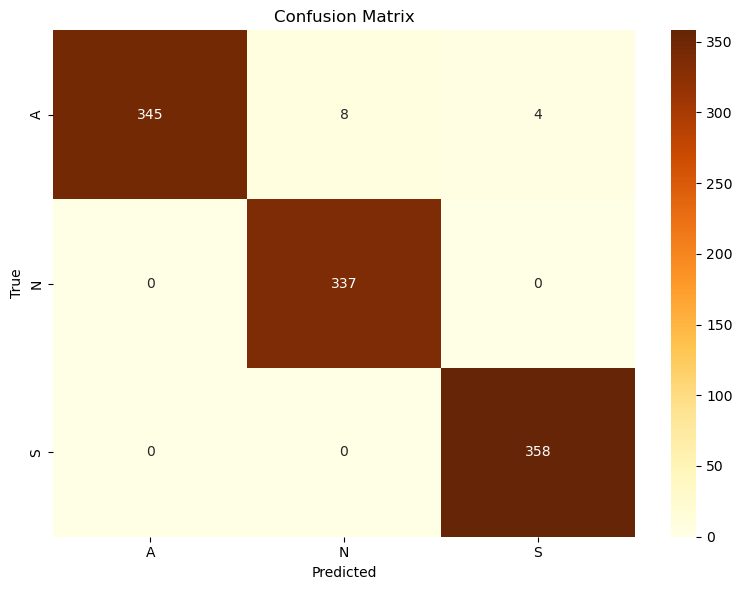

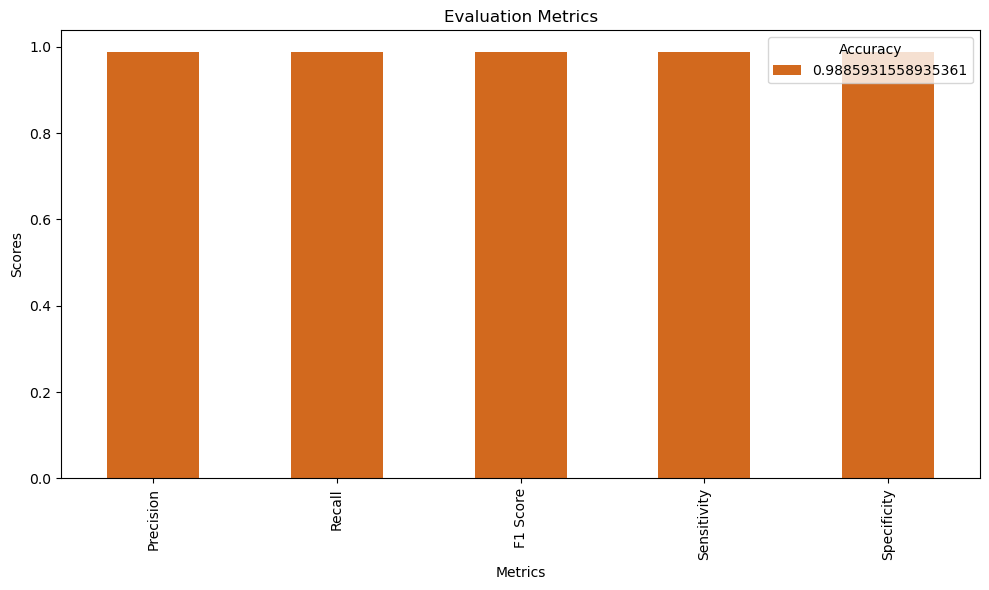

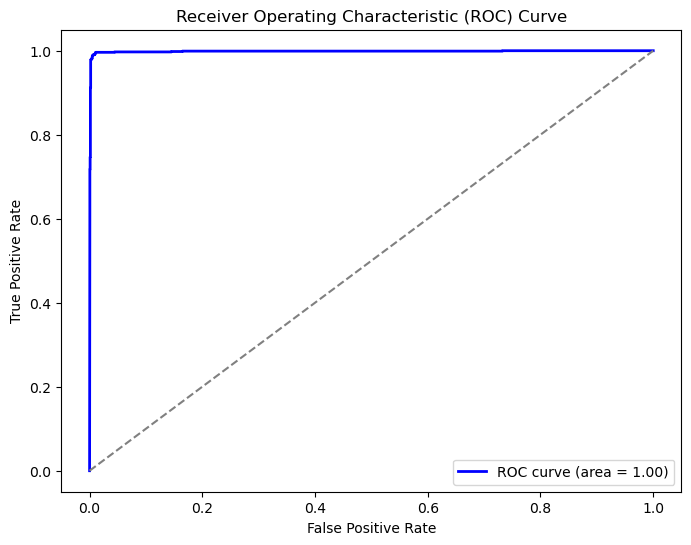

In [25]:
import seaborn as sns
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np

# Create a directory for saving results
result_dir = "model_results"
os.makedirs(result_dir, exist_ok=True)

# Predict on test set
model.eval()
with torch.no_grad():
    outputs = model(X_test)
    _, predicted = torch.max(outputs, 1)

# Compute confusion matrix
cm = confusion_matrix(y_test.cpu(), predicted.cpu())
cm_df = pd.DataFrame(cm, index=label_encoder.classes_, columns=label_encoder.classes_)

# Compute precision, recall, f1-score
precision = precision_score(y_test.cpu(), predicted.cpu(), average='weighted')
recall = recall_score(y_test.cpu(), predicted.cpu(), average='weighted')
f1 = f1_score(y_test.cpu(), predicted.cpu(), average='weighted')
accuracy = accuracy_score(y_test.cpu(), predicted.cpu())

# Compute sensitivity and specificity
sensitivity = recall_score(y_test.cpu(), predicted.cpu(), pos_label=1, average='weighted')  # for class 1
specificity = recall_score(y_test.cpu(), predicted.cpu(), pos_label=0, average='weighted')  # for class 0

# Save confusion matrix with the 'YlOrBr' color map (Yellow-Orange-Brown)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='YlOrBr', cbar=True)  # YlOrBr color map
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
confusion_matrix_path = os.path.join(result_dir, "confusion_matrix_YlOrBr.svg")
plt.savefig(confusion_matrix_path, format='svg', dpi=300)  # Save as SVG with 300 DPI
plt.show()

# Save evaluation metrics to CSV
eval_metrics = {
    "Accuracy": [accuracy],
    "Precision": [precision],
    "Recall": [recall],
    "F1 Score": [f1],
    "Sensitivity": [sensitivity],
    "Specificity": [specificity]
}

eval_df = pd.DataFrame(eval_metrics)
eval_csv_path = os.path.join(result_dir, "evaluation_metrics.csv")
eval_df.to_csv(eval_csv_path, index=False)

# Bar plot for evaluation metrics with 'chocolate' color
plt.figure(figsize=(10, 6))
eval_df.set_index('Accuracy').T.plot(kind='bar', color='chocolate', ax=plt.gca())  # Chocolate color
plt.title('Evaluation Metrics')
plt.ylabel('Scores')
plt.xlabel('Metrics')
plt.tight_layout()
eval_barplot_path = os.path.join(result_dir, "evaluation_metrics_barplot_chocolate.svg")
plt.savefig(eval_barplot_path, format='svg', dpi=300)  # Save as SVG with 300 DPI
plt.show()

# Compute and save AUC-ROC curve (multi-class handling)
y_test_bin = label_binarize(y_test.cpu(), classes=np.arange(num_classes))
predictions_prob = torch.softmax(model(X_test), dim=1).cpu().detach().numpy()

# Calculate AUC for each class
roc_auc = roc_auc_score(y_test_bin, predictions_prob, average='macro', multi_class='ovr')

# Compute ROC curve for each class
fpr, tpr, _ = roc_curve(y_test_bin.ravel(), predictions_prob.ravel())

# Plot the ROC curve with dots at fluctuation points
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')

# Mark fluctuation points (e.g., points at fpr=0.05, 0.1, 0.5)
for point in [0.05, 0.1, 0.5]:
    if point in fpr:
        index = list(fpr).index(point)
        plt.scatter(fpr[index], tpr[index], color='red', marker='o', label=f'Fluctuation Point (FPR={point})')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')

# Save AUC curve with fluctuation points
roc_curve_path = os.path.join(result_dir, "roc_curve_with_fluctuations.svg")
plt.savefig(roc_curve_path, format='svg', dpi=300)
plt.show()


# Balancing Dataset

In [65]:
import pandas as pd
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler

# Load your gene expression dataset
df = pd.read_csv('nan_filled_dataset.csv')

# Split the dataset into features (X) and target (y)
X = df.drop(columns=['Sample_ID', 'Condition'])  # Drop Sample_Id and Condition columns
y = df['Condition']

# 1. SMOTE for oversampling the minority class
smote = SMOTE(sampling_strategy='auto', random_state=42)  # You can change strategy to a fixed number if desired

# Apply SMOTE to balance the dataset
X_resampled, y_resampled = smote.fit_resample(X, y)

# Combine the resampled features and target back into a DataFrame
df_resampled = pd.DataFrame(X_resampled, columns=X.columns)
df_resampled['Condition'] = y_resampled

# Optionally, add the 'Sample_Id' column if needed (can be randomly generated or retained if original Sample_Id was important)
df_resampled['Sample_Id'] = ['s'+str(i) for i in range(1, len(df_resampled) + 1)]

# Save the balanced dataset to a CSV file
df_resampled.to_csv('balanced_gene_expression_data.csv', index=False)

print("Balanced dataset saved to 'balanced_gene_expression_data.csv'")


KeyboardInterrupt: 

In [68]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder

# --- Device Setup ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🚀 Using device: {device}")

# Load your gene expression dataset
df = pd.read_csv('nan_filled_dataset.csv')

# --- Separate non-numeric and numeric columns ---
numeric_columns = df.select_dtypes(include=[np.number]).columns  # Select numeric columns
non_numeric_columns = df.select_dtypes(exclude=[np.number]).columns  # Select non-numeric columns

# --- Handle Missing Values (NaN) ---
# Fill NaN values in numeric columns with the median of each column
df[numeric_columns] = df[numeric_columns].fillna(df[numeric_columns].median())

# --- Split the dataset into features (X) and target (y) ---
X = df.drop(columns=['Sample_ID', 'Condition'])  # Drop Sample_ID and Condition columns
y = df['Condition']  # Target label

# --- Encode target labels (Condition) ---
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# --- Standardize the data (Feature Scaling) ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)  # Apply scaling only to the features

# Convert data to PyTorch tensors
X_tensor = torch.tensor(X_scaled, dtype=torch.float32).to(device)
y_tensor = torch.tensor(y_encoded, dtype=torch.long).to(device)  # Now it's numeric

# --- Identify Minority Classes (N and S) ---
minority_classes = ['N', 'S']
X_minority = X_tensor[(y == label_encoder.transform(['N'])[0]) | (y == label_encoder.transform(['S'])[0])]  # Features of minority classes
y_minority = y_tensor[(y == label_encoder.transform(['N'])[0]) | (y == label_encoder.transform(['S'])[0])]  # Labels of minority classes

# --- Define the GAN Models ---

# Generator
class Generator(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 256)
        self.fc3 = nn.Linear(256, 512)
        self.fc4 = nn.Linear(512, output_dim)
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()

    def forward(self, z):
        x = self.relu(self.fc1(z))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.tanh(self.fc4(x))
        return x

# Discriminator
class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(input_dim, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.sigmoid(self.fc4(x))
        return x

# --- Initialize Models ---
input_dim = X_minority.shape[1]  # Number of features in the minority class dataset
latent_dim = 100  # Dimension of random noise

generator = Generator(latent_dim, input_dim).to(device)
discriminator = Discriminator(input_dim).to(device)

# --- Loss and Optimizers ---
adversarial_loss = nn.BCELoss()
optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

# --- Training the GAN ---
def train_gan(generator, discriminator, optimizer_G, optimizer_D, adversarial_loss, X_minority_tensor, epochs=10000, batch_size=64, sample_interval=1000):
    half_batch = batch_size // 2
    for epoch in range(epochs):
        # Train discriminator
        idx = torch.randint(0, X_minority_tensor.size(0), (half_batch,))
        real_samples = X_minority_tensor[idx]
        real_labels = torch.ones(half_batch, 1).to(device)

        noise = torch.randn(half_batch, latent_dim).to(device)
        fake_samples = generator(noise)
        fake_labels = torch.zeros(half_batch, 1).to(device)

        # Discriminator loss
        optimizer_D.zero_grad()
        real_loss = adversarial_loss(discriminator(real_samples), real_labels)
        fake_loss = adversarial_loss(discriminator(fake_samples.detach()), fake_labels)
        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        optimizer_D.step()

        # Train generator
        optimizer_G.zero_grad()
        g_loss = adversarial_loss(discriminator(fake_samples), real_labels)
        g_loss.backward()
        optimizer_G.step()

        # Print the progress
        if epoch % sample_interval == 0:
            print(f"{epoch} [D loss: {d_loss.item()}] [G loss: {g_loss.item()}]")

# Train the GAN
train_gan(generator, discriminator, optimizer_G, optimizer_D, adversarial_loss, X_minority_tensor)

# --- Generate Synthetic Data ---
def generate_synthetic_samples(generator, num_synthetic_samples, latent_dim):
    noise = torch.randn(num_synthetic_samples, latent_dim).to(device)
    synthetic_samples = generator(noise)
    synthetic_samples_rescaled = synthetic_samples.detach().cpu().numpy()
    synthetic_samples_rescaled = scaler.inverse_transform(synthetic_samples_rescaled)
    return synthetic_samples_rescaled

# Number of synthetic samples for each class
num_synthetic_samples_N = 500  # Adjust the number for class "N"
num_synthetic_samples_S = 500  # Adjust the number for class "S"

synthetic_samples_N = generate_synthetic_samples(generator, num_synthetic_samples_N, latent_dim)
synthetic_samples_S = generate_synthetic_samples(generator, num_synthetic_samples_S, latent_dim)

# --- Decode the labels back to the original categorical values ---
# Since synthetic data is for the minority class, we set the condition as the original classes
synthetic_df_N = pd.DataFrame(synthetic_samples_N, columns=X.columns)
synthetic_df_N['Condition'] = 'N'
synthetic_df_N['Sample_ID'] = ['synthetic' + str(i) for i in range(1, num_synthetic_samples_N + 1)]

synthetic_df_S = pd.DataFrame(synthetic_samples_S, columns=X.columns)
synthetic_df_S['Condition'] = 'S'
synthetic_df_S['Sample_ID'] = ['synthetic' + str(i + num_synthetic_samples_N) for i in range(1, num_synthetic_samples_S + 1)]

# --- Combine Original and Synthetic Data ---
df_balanced = pd.concat([df, synthetic_df_N, synthetic_df_S], ignore_index=True)

# Save the balanced dataset to a CSV file
df_balanced.to_csv('balanced_gene_expression_data_with_GAN_pytorch.csv', index=False)

print("Balanced dataset saved to 'balanced_gene_expression_data_with_GAN_pytorch.csv'")


🚀 Using device: cuda
0 [D loss: 0.6931952238082886] [G loss: 0.6767953634262085]
1000 [D loss: 0.49722397327423096] [G loss: 1.05328369140625]
2000 [D loss: 0.6725450754165649] [G loss: 0.920664370059967]
3000 [D loss: 0.4417828619480133] [G loss: 1.1541211605072021]
4000 [D loss: 0.4996292293071747] [G loss: 1.2477210760116577]
5000 [D loss: 0.4092254936695099] [G loss: 1.2396416664123535]
6000 [D loss: 0.5286966562271118] [G loss: 1.132190227508545]
7000 [D loss: 0.4551467299461365] [G loss: 1.2772870063781738]
8000 [D loss: 0.441035658121109] [G loss: 1.3102800846099854]
9000 [D loss: 0.47849348187446594] [G loss: 1.2209566831588745]
Balanced dataset saved to 'balanced_gene_expression_data_with_GAN_pytorch.csv'
